In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline
import theano.tensor as T
import scipy.stats as stats
from scipy.interpolate import griddata

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Detecting spurious/false relationships
In the next section we will learn to detect spurious correlations (between marriage rate and divorce). 
### Multivariate Regression
Linear regression between multiple varibles and one outcome. Not to be confused with hierarchical regression which has multiple outcomes.
Multivariate regression helps us distringuish mere association/correlation from evidence of causation.

In [ ]:
# load data
d = pd.read_csv('Data/WaffleDivorce.txt', sep=';')

# standardize median marriage age predictor
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()
# standardize marriage rate predictor
d['Marriage_s'] = (d['Marriage'] - d['Marriage'].mean())/d['Marriage'].std()

In [ ]:
d.head()

The second plot below appears to illustrate a positive correlation between marriage rate and divorce rate. But one should ask why; does this make sense? If a population gets married at a faster rate, wouldn't it mean that they value marriage more than those getting married at a slower rate; thus, leading to lower divorce rate. In section 5.4, we will check how spurious the relationship is between the two.


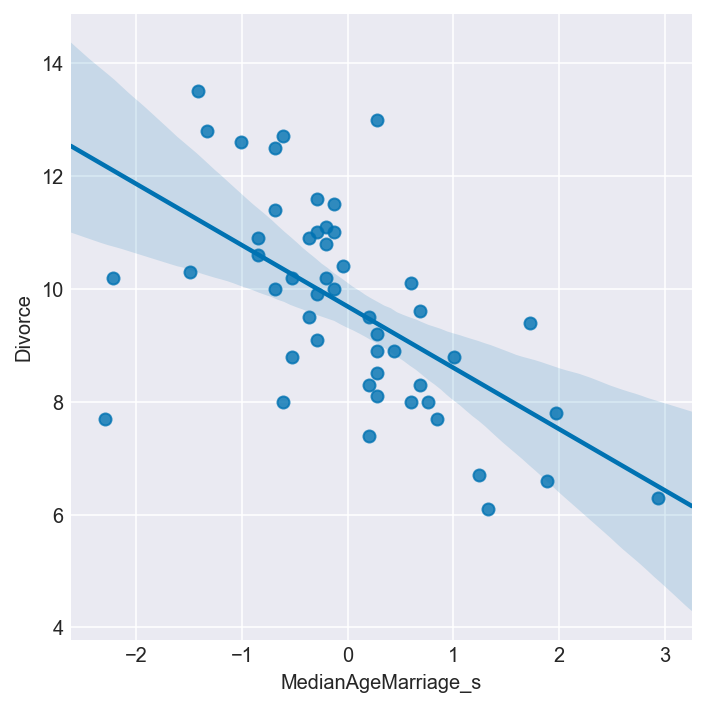

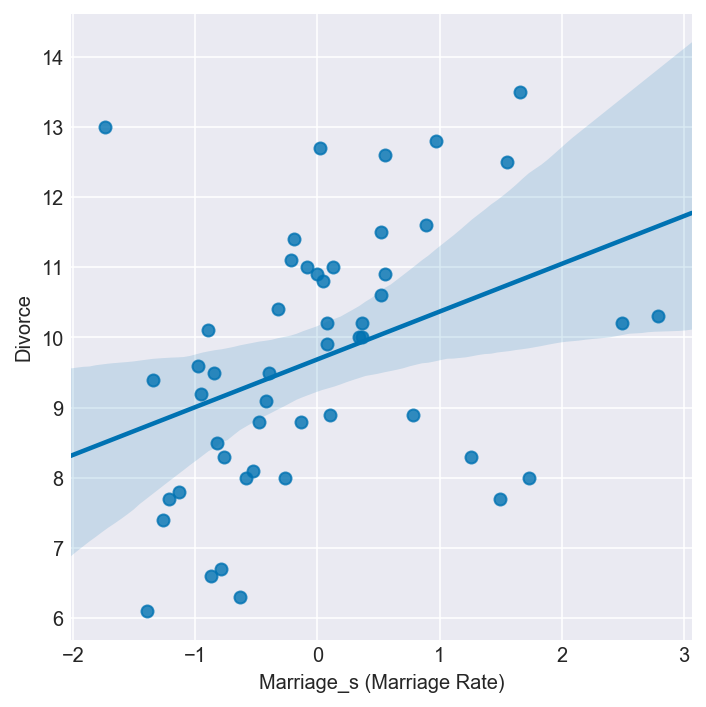

In [5]:
sns.lmplot('MedianAgeMarriage_s','Divorce', data=d);
sns.lmplot('Marriage_s','Divorce', data=d)
plt.xlabel('Marriage_s (Marriage Rate)');
print("The second plot below appears to illustrate a positive correlation between marriage rate and divorce rate. \
But one should ask why; does this make sense? If a population gets married at a faster rate, wouldn't it mean that \
they value marriage more than those getting married at a slower rate; thus, leading to lower divorce rate. In section 5.4, \
we will check how spurious the relationship is between the two.")

**5.1**

Compute the linear regression between Marriage Age and Divorce (instead of using seaborn's default regression above) 

\begin{aligned}
D_i &\sim Normal(μ_i,σ)\\
μ_i &= α+β_AMarriage_i\\
α &\sim Normal(10,10)\\
β_A &\sim Normal(0,1)\\
σ &\sim Uniform(0,10)
\end{aligned}

In [6]:
with pm.Model() as model_5_1:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # good (default) alternatives for sigma (in this and other models) are:
    # sigma1 = pm.HalfNormal('sigma1', 5)
    # sigma2 = pm.HalfCauchy('sigma2', 5)
    # some people recomed avoiding "hard" (uniform) boundaries unless they have a theoretical/data-based justification, 
    # like a correlation that is restricted to be [-1, 1]. Using sigma1 would be better here because its prior gives more
    # probability around 1 than around higher numbers, while sigma gives equal probability b/w 1-10.
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_1 = pm.sample(4000, tune=2000)
    
    prior = pm.sample_prior_predictive() # use this to view prior distribution outside the model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 12000/12000 [00:23<00:00, 510.28draws/s]


In [7]:
pm.summary(trace_5_1).head()

mean        sd  mc_error   hpd_2.5   hpd_97.5         n_eff  \
a       9.687552  0.211796  0.002242  9.272601  10.099965   9676.856371   
bA     -1.037327  0.215099  0.002117 -1.480050  -0.634782  10383.468486   
sigma   1.515303  0.159612  0.001326  1.223603   1.834748  10200.998330   
mu__0  10.316473  0.250671  0.002820  9.840729  10.813769   8854.591867   
mu__1  10.399884  0.260337  0.002931  9.883994  10.900150   8848.002447   

           Rhat  
a      1.000194  
bA     1.000212  
sigma  1.000179  
mu__0  0.999906  
mu__1  0.999892

In [8]:
g = pm.trace_to_dataframe(trace_5_1, varnames=['a','bA','sigma'])
g.corr()

a        bA     sigma
a      1.000000 -0.017580  0.000258
bA    -0.017580  1.000000  0.077135
sigma  0.000258  0.077135  1.000000

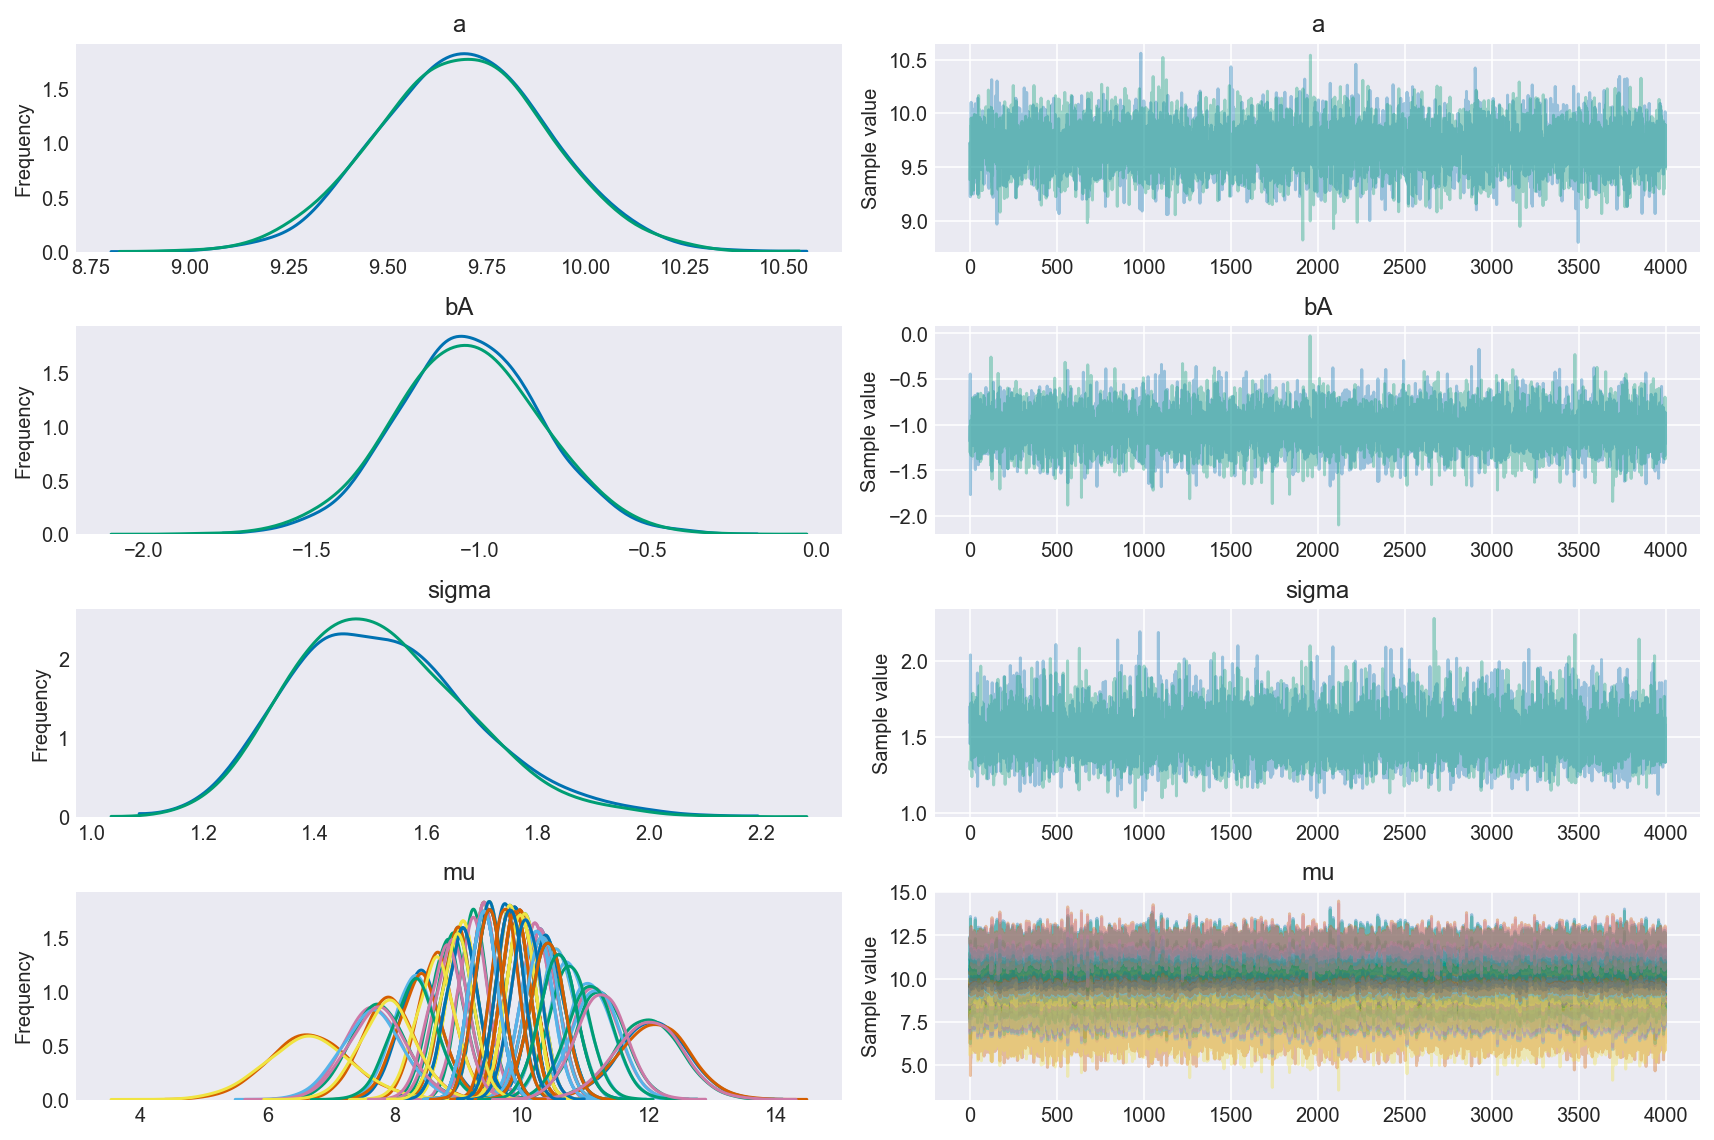

In [9]:
pm.traceplot(trace_5_1);

**5.2**

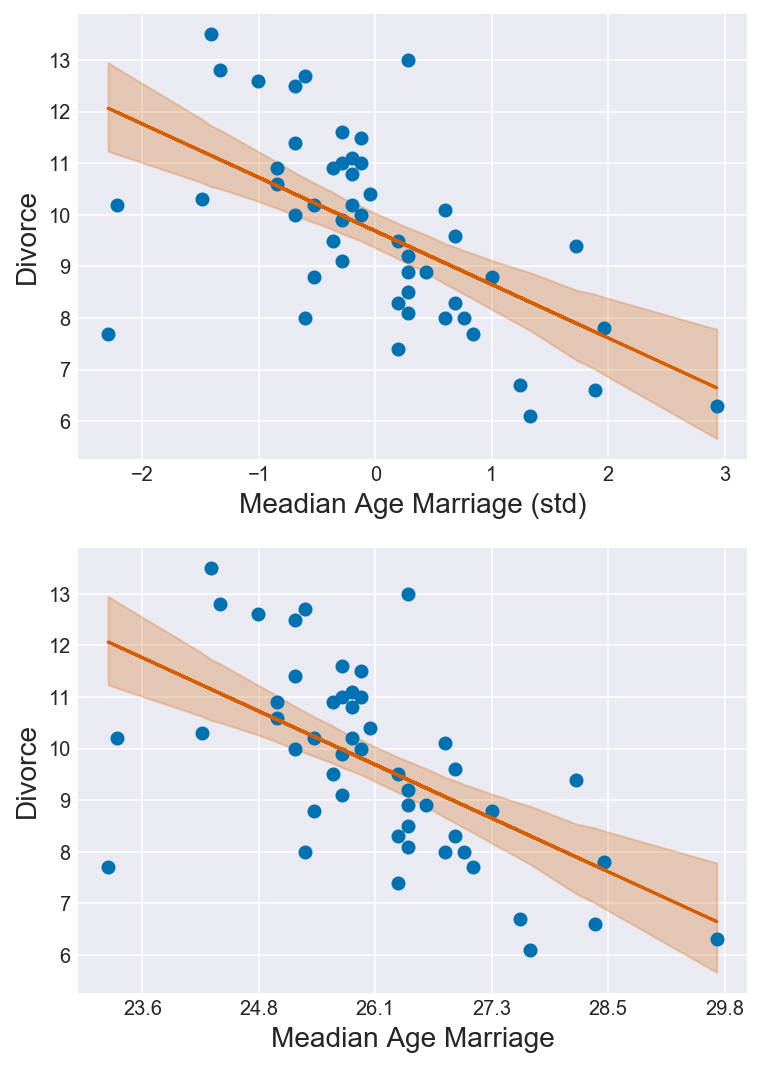

In [12]:
mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean, alpha=0.11) # 87% HPD interval of mu

plt.figure(figsize=(6,9))
plt.subplot(2,1,1)
plt.plot(d.MedianAgeMarriage_s, d.Divorce, 'C0o')
plt.plot(d.MedianAgeMarriage_s, mu_mean.mean(0), 'C2')
# above is same as: plt.plot(d.MedianAgeMarriage_s, trace_5_1['a'].mean() + 
# trace_5_1['bA'].mean()*d.MedianAgeMarriage_s)

idx = np.argsort(d.MedianAgeMarriage_s)
plt.fill_between(d.MedianAgeMarriage_s[idx],
                 mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Meadian Age Marriage (std)', fontsize=14)
plt.ylabel('Divorce', fontsize=14);


plt.subplot(2,1,2)
plt.plot(d.MedianAgeMarriage_s, d.Divorce, 'C0o')
plt.plot(d.MedianAgeMarriage_s, mu_mean.mean(0), 'C2')
idx = np.argsort(d.MedianAgeMarriage_s)
plt.fill_between(d.MedianAgeMarriage_s[idx],
                 mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Meadian Age Marriage', fontsize=14)
plt.ylabel('Divorce', fontsize=14)

#convert back to natural scale.
at = np.arange(-2,4)
plt.xticks(at, np.round(at * d['MedianAgeMarriage'].std() + 
                        d['MedianAgeMarriage'].mean(), 1));


In [13]:
change_rate_of_slope = pm.hpd(trace_5_1['bA'], alpha=0.11) #89% HPDI
change_rate_of_slope

array([-1.36083616, -0.67897679])

We see that for every +1 standard deviation in Meadian Age Marriage (~ 1.2 years), the divorce rate decreases by -1.03 (bA) for every 1000 adults, with a 89% hpd interval from -1.36 to -0.69. The slope is reliably negative.

**5.3**

Compute the linear regression between Marriage Rate and Divorce 

In [14]:
with pm.Model() as model_5_2:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    #sigma = pm.Uniform('sigma', lower=0, upper=10)
    sigma1 = pm.HalfNormal('sigma1', 5)

    mu = pm.Deterministic('mu', a + bA * d.Marriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma1, observed=d.Divorce)
    trace_5_2 = pm.sample(4000, tune=2000)
    
    prior = pm.sample_prior_predictive() 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma1, bA, a]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 12000/12000 [00:22<00:00, 532.34draws/s]


In [15]:
pm.summary(trace_5_2).head()

mean        sd  mc_error   hpd_2.5   hpd_97.5        n_eff  \
a        9.687443  0.251131  0.002387  9.183762  10.174427  9863.483711   
bA       0.637735  0.243515  0.002377  0.158313   1.104427  9663.167711   
sigma1   1.750718  0.182826  0.001740  1.412234   2.115080  9517.355755   
mu__0    9.701883  0.251117  0.002390  9.197676  10.187334  9873.099529   
mu__1   10.675805  0.450488  0.004497  9.767472  11.538183  9926.811858   

            Rhat  
a       1.000188  
bA      0.999977  
sigma1  0.999922  
mu__0   1.000196  
mu__1   1.000211

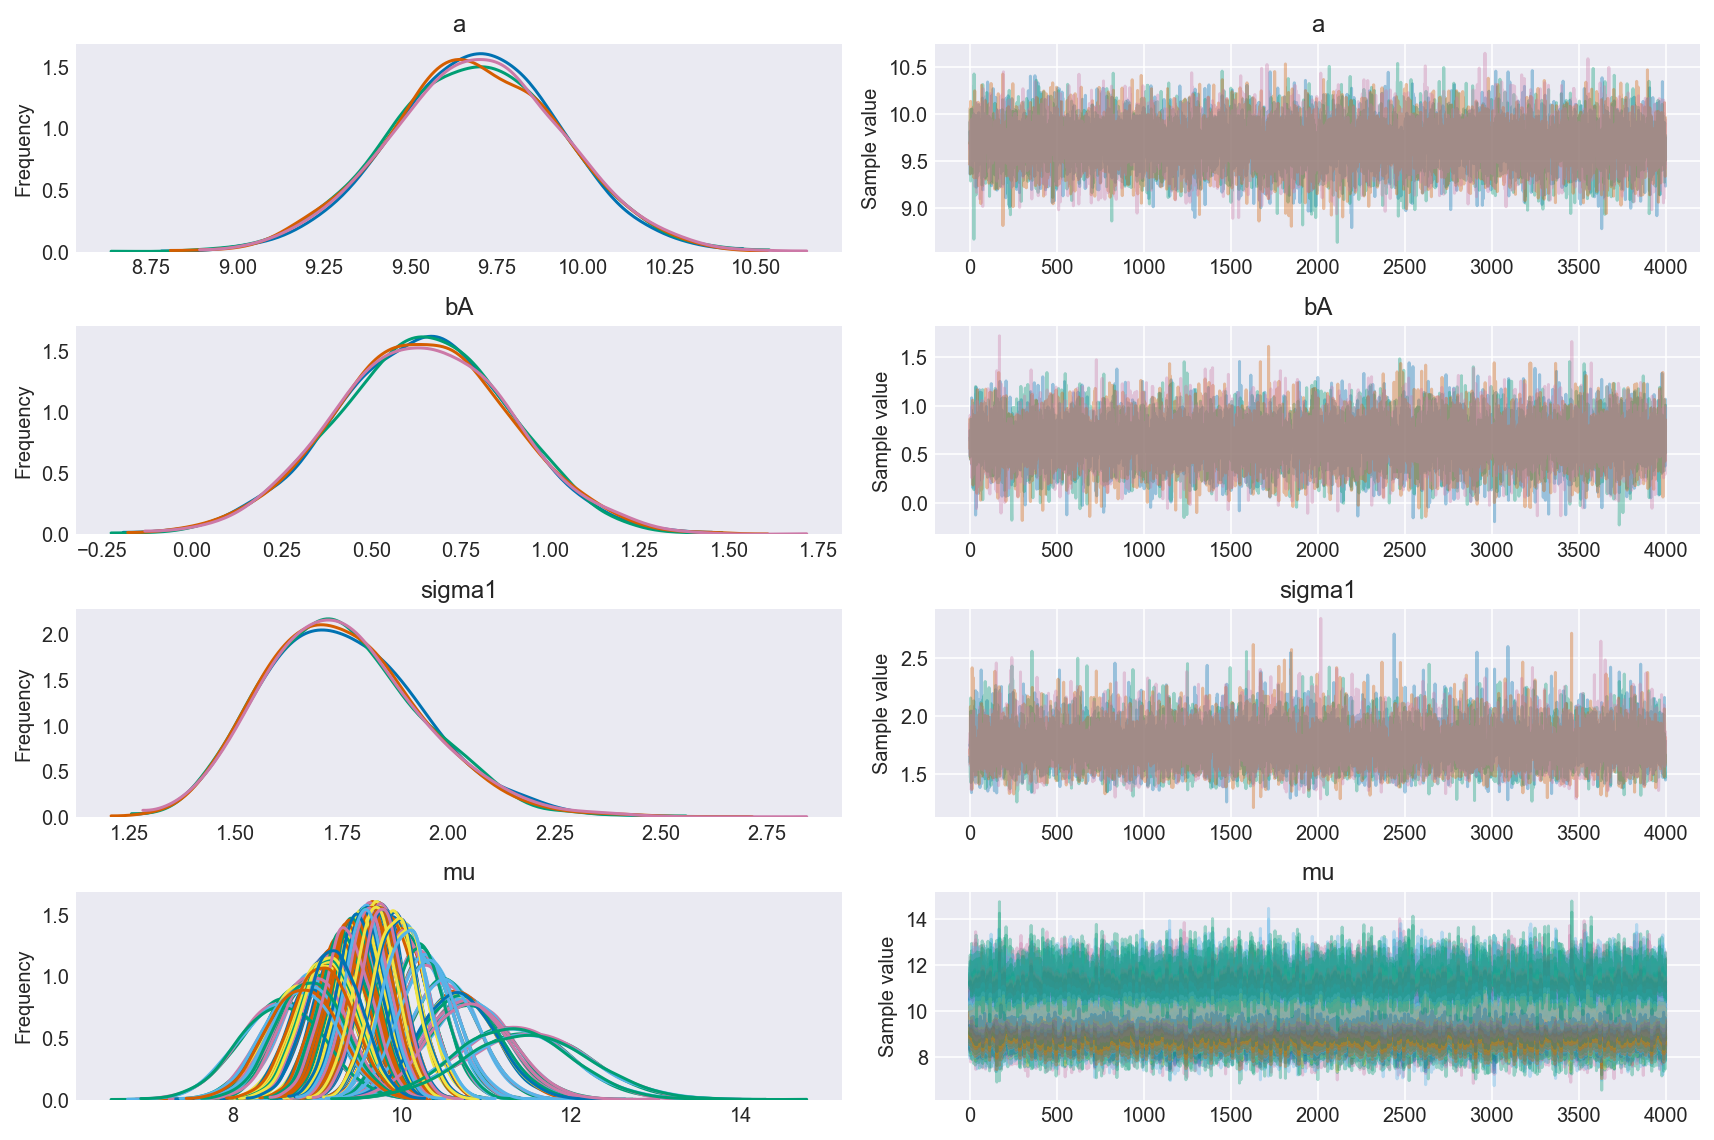

In [11]:
pm.traceplot(trace_5_2);

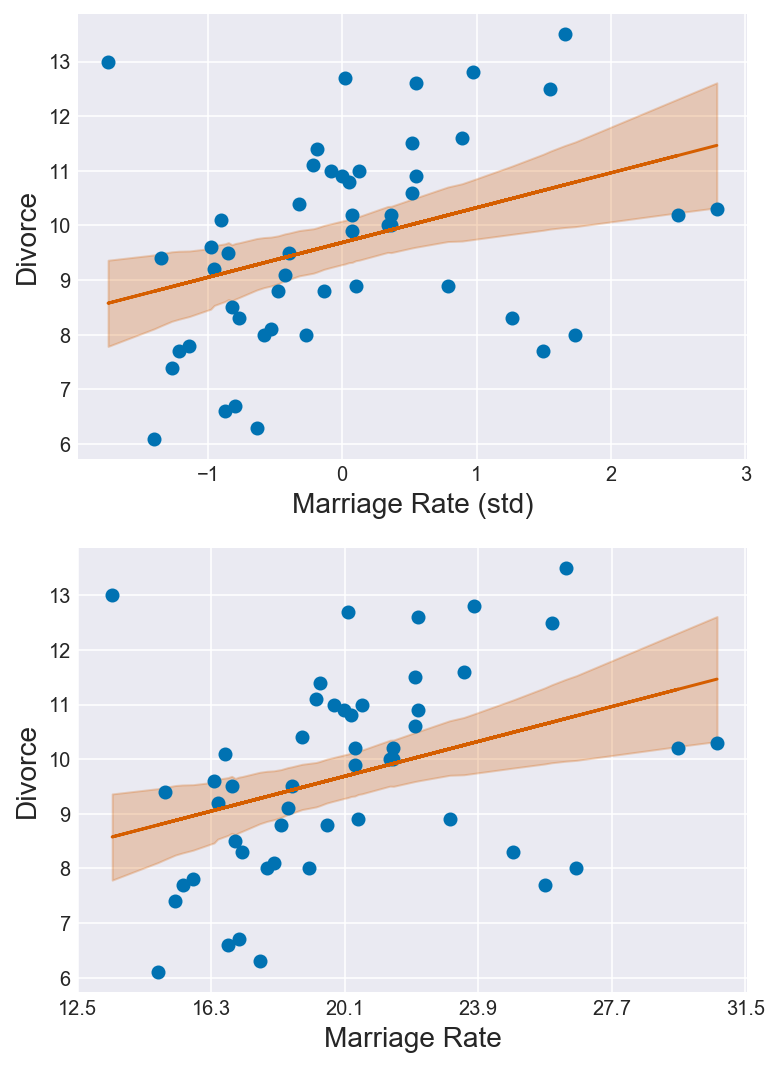

In [17]:
mu_mean_2 = trace_5_2['mu']
mu_hpd_2 = pm.hpd(mu_mean_2, alpha=0.11) # 87% HPD interval of mu

plt.figure(figsize=(6,9))
plt.subplot(2,1,1)
plt.plot(d.Marriage_s, d.Divorce, 'C0o')
plt.plot(d.Marriage_s, mu_mean_2.mean(0), 'C2')
# above is same as: plt.plot(d.Marriage_s, trace_5_2['a'].mean() + trace_5_2['bA'].mean()*d.Marriage_s)

idx = np.argsort(d.Marriage_s)
plt.fill_between(d.Marriage_s[idx],
                 mu_hpd_2[:,0][idx], mu_hpd_2[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Marriage Rate (std)', fontsize=14)
plt.ylabel('Divorce', fontsize=14);


plt.subplot(2,1,2)
plt.plot(d.Marriage_s, d.Divorce, 'C0o')
plt.plot(d.Marriage_s, mu_mean_2.mean(0), 'C2')
idx = np.argsort(d.Marriage_s)
plt.fill_between(d.Marriage_s[idx],
                 mu_hpd_2[:,0][idx], mu_hpd_2[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Marriage Rate', fontsize=14)
plt.ylabel('Divorce', fontsize=14)

#convert back to natural scale.
at = np.arange(-2,4)
plt.xticks(at, np.round(at * d['Marriage'].std() + 
                        d['Marriage'].mean(), 1));

In [18]:
change_rate_of_slope_2 = pm.hpd(trace_5_2['bA'], alpha=0.11) #89% HPDI
change_rate_of_slope_2

array([0.24897196, 1.0178412 ])

We see that for every +1 standard deviation in Marriage rate (~ 3.8 people for every 1000), the divorce rate increases by 0.63 (bA) for every 1000 adults, with a 89% hpd interval from 0.24 to 1.01. The slope is reliably positive. In addition, the model residual is 1.75 (sigma), which is higher than the residual of the median marriage age model of 1.51. A lower residual is usually a sign that the predictor explains more of the change/variation in the outcome.

**5.4**

It appears that the Median Marriage age is a better predictor than the Marriage Rate, but comparing them like we did, using two separate bivariate regressions is not a good way. Both of these predictors could provide independent value, or they could be redundant, or one could eliminate the value of the other. 

So we shall use the multivariate regression to answer the following:
* what is the predictive value of a variable once I already know all the other predictor variables?
* That is, once I already know marriage rate, what is the additional value in also knowing median age of marriage?

\begin{aligned}
D_i &\sim Normal(μ_i,σ)\\
μ_i &= α+β_RR_i+β_AA_i\\
α &\sim Normal(10,10)\\
β_R &\sim Normal(0,1)\\
β_A &\sim Normal(0,1)\\
σ &\sim Uniform(0,10)
\end{aligned}

In [19]:
with pm.Model() as model_5_3:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a +  bA[0] * d.Marriage_s + bA[1] * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_3 = pm.sample(4000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 12000/12000 [00:34<00:00, 658.75draws/s]


In [25]:
pm.summary(trace_5_3).head()

mean        sd  mc_error   hpd_2.5   hpd_97.5        n_eff  \
a       9.685719  0.219616  0.002502  9.244867  10.101639  7030.146443   
bA__0  -0.122550  0.294089  0.004907 -0.685580   0.460491  4696.871801   
bA__1  -1.121547  0.293862  0.004645 -1.654398  -0.513944  4880.253472   
sigma   1.526441  0.161083  0.002174  1.232351   1.849018  5909.184803   
mu__0  10.362926  0.279879  0.003450  9.811978  10.898803  6293.725980   

           Rhat  
a      0.999884  
bA__0  1.000028  
bA__1  1.000468  
sigma  0.999922  
mu__0  1.000039

We see that the affect of Marriage rate (-0.12) on outcome of Divorce is less significant than when modeled as a bivariate regression (-0.63). But the affect of Marriage Age has become more signigicant, from -1.03 to -1.12. The model shows us that once we know the median marriage age, there is litte additional predictive value in knowing marriage rate.

Another way of seeing this. The relationship between divorce and marriage rate, after statistically "controlling" for median age of marriage, is -0.12: not very significant.

The relationship between divorce and median age of marriage, after statistically "controlling" for marriage rate, is -1.12: a lot more significant.

**5.5**

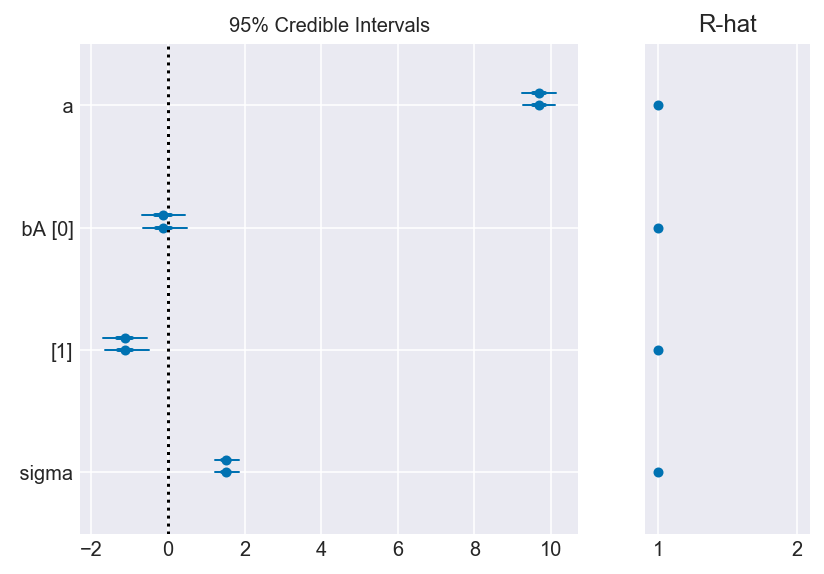

In [30]:
varnames = ['a','bA','sigma']
pm.forestplot(trace_5_3, varnames=varnames);

# Visualization of the Posterior
(Predictor Residual Plots, Counterfactual Plots, Posterior Prediction Plots)

### Predictor Residual Plots

These plots show the outcome against residual predictor values. It is defined as the average prediction error when we use all of the other predictor variables (Median Marriage age) to model a predictor of interest (Marriage Rate).

\begin{aligned}
R_i &\sim Normal(μ_i,σ)\\
μ_i &= α+βA_i\\
α &\sim Normal(0,10)\\
β_A &\sim Normal(0,1)\\
σ &\sim Uniform(0,10)
\end{aligned}

* alpha's mu = 0 because both variables were standardized
* R = Marriage Rate
* βA = Median Marriage Age

**5.6**
### Relationship between Marriage Rate and Divorce, after controlling for Median Age of Marriage.

In [282]:
with pm.Model() as model_MrgRate_control_Age:
    a = pm.Normal('a', mu=0, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a +  bA * d.MedianAgeMarriage_s)
    Marriage_Rate = pm.Normal('Marriage_Rate', mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_MrgRate_control_Age = pm.sample(4000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 12000/12000 [00:26<00:00, 459.00draws/s]


In [316]:
pm.summary(trace_MrgRate_control_Age).head()

mean        sd  mc_error   hpd_2.5  hpd_97.5         n_eff  \
a      0.000216  0.102347  0.000981 -0.196985  0.200641  12302.526710   
bA    -0.712329  0.104941  0.001055 -0.930088 -0.514933  11238.828153   
sigma  0.719307  0.075194  0.000720  0.585576  0.870951  10115.844879   
mu__0  0.432094  0.121218  0.001101  0.190682  0.667713  12365.038575   
mu__1  0.489372  0.125942  0.001143  0.241481  0.735440  12345.987543   

           Rhat  
a      1.000257  
bA     0.999884  
sigma  1.000055  
mu__0  1.000098  
mu__1  1.000075

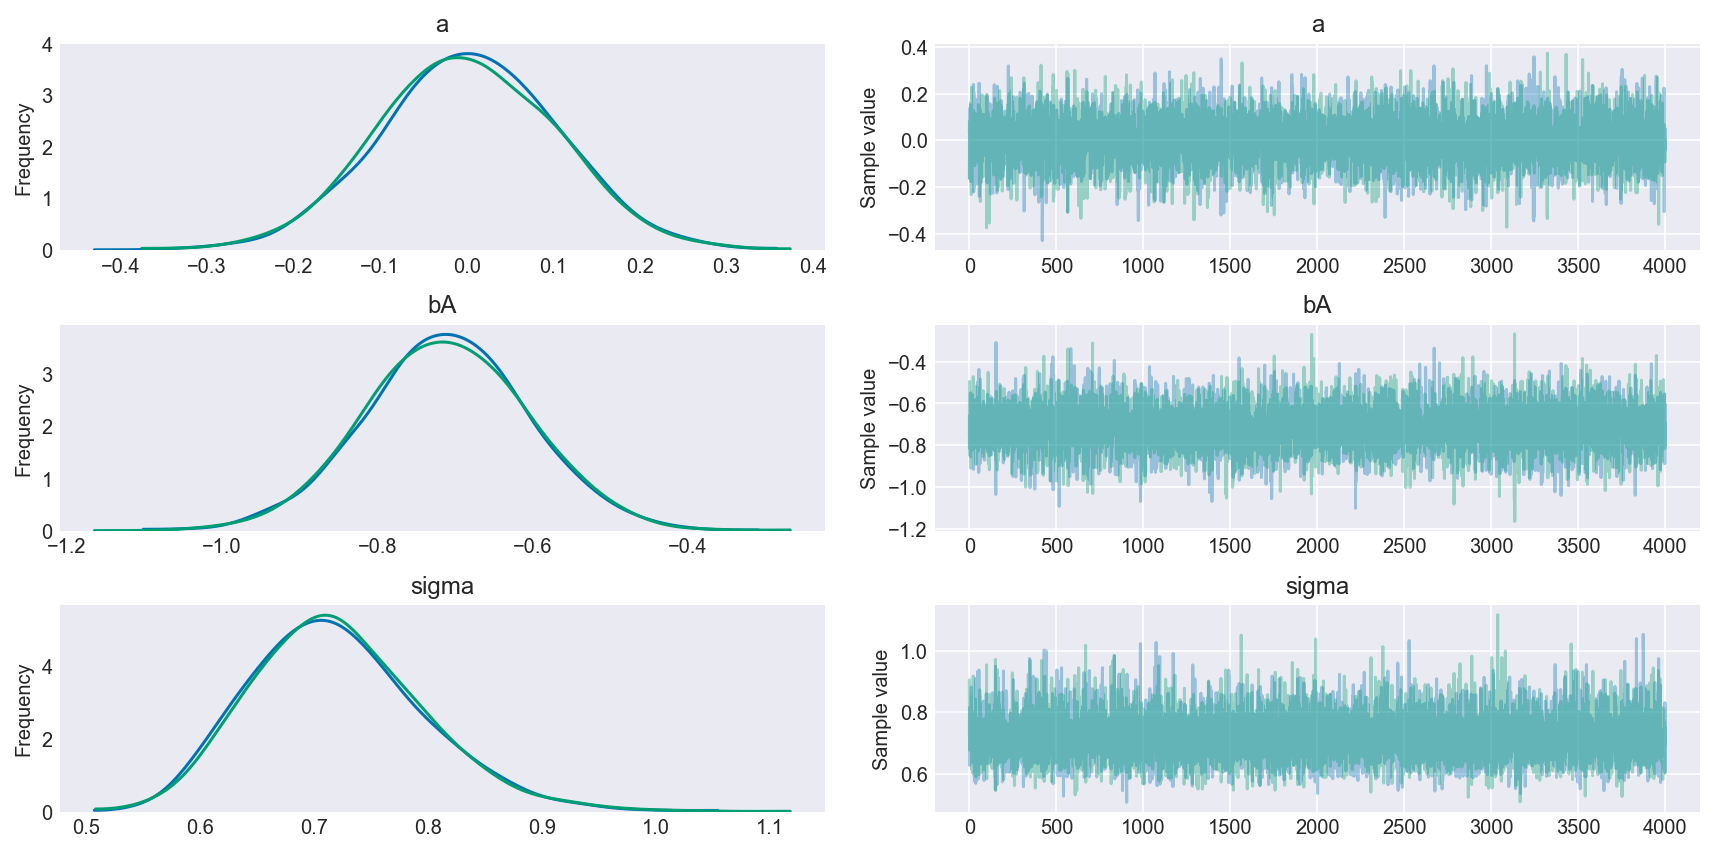

In [284]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_MrgRate_control_Age, varnames);

**5.7**

Compute the residuals by subtracting the observed marriage rate in each state from the predicted rate.

In [285]:
mu_pred_4 = trace_MrgRate_control_Age['mu'].mean(0)
# observed marriage rate minus predicted marriage rate
residuals_4 = d.Marriage_s - mu_pred_4

**Residual plot between predictors**

Visualizing the residuals between the predictor variables

**5.8**

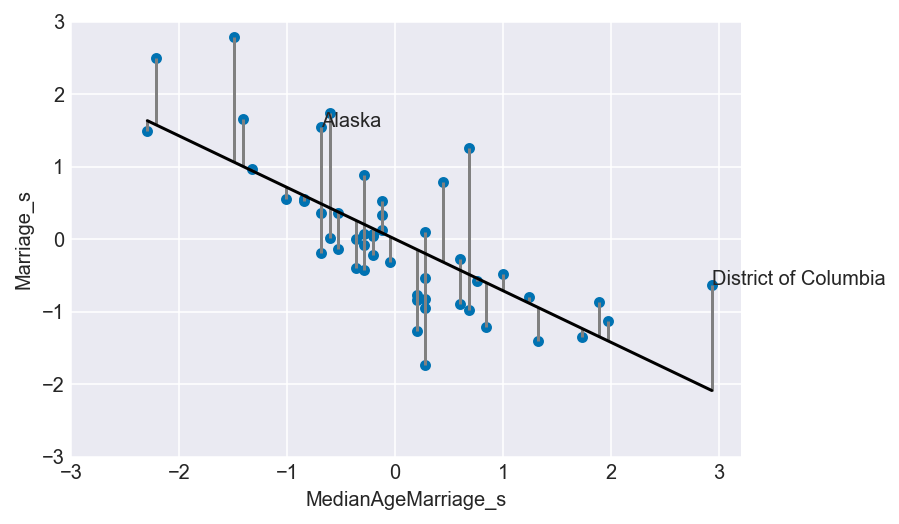

In [365]:
idx = np.argsort(d.MedianAgeMarriage_s)
d.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim = (-3, 3.2), ylim = (-3, 3))
plt.plot(d.MedianAgeMarriage_s[idx], mu_pred_4[idx], 'k') # regression line of predicted marriage rate
plt.vlines(d.MedianAgeMarriage_s, mu_pred_4, mu_pred_4 + residuals_4, colors='grey')

plt.annotate(d.Location[8], (d.MedianAgeMarriage_s[8],d.Marriage_s[8]))
plt.annotate(d.Location[1], (d.MedianAgeMarriage_s[1],d.Marriage_s[1]));

When the residual is positive, that means that the observed rate was in excess of what we'd expect, given the median marriage age in that State. When it's negative, it means the observed rate was below that which was expected.

In other words, states with positive residuals marry fast for their age of marriage. For example, the marriage rate in the District of Columbia is a lot higher than expected for the State's median age of marriage

**Overlay residuals against linear regression**

Now, let's plot the above residuals between the two predictors against the outcome of interest: Divorce rate

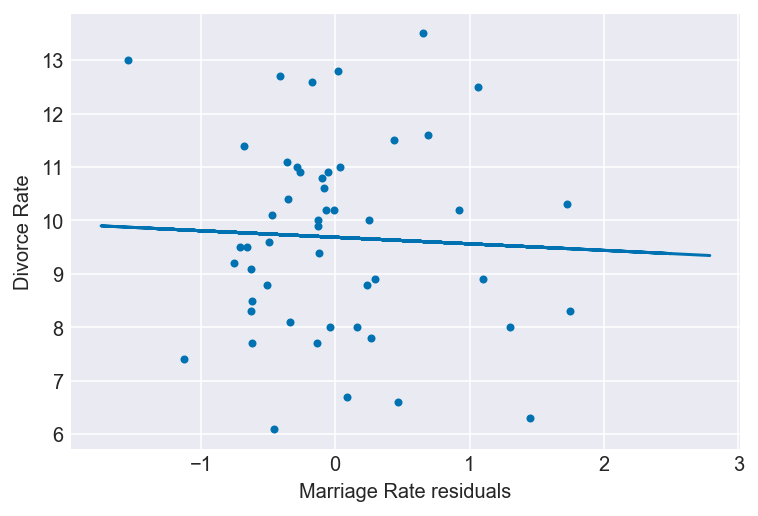

In [388]:
mu_pred_MarriageRate = trace_5_3['a'].mean() + trace_5_3['bA'][:,0].mean() * d.Marriage_s

plt.plot(residuals_4, d.Divorce, '.')
# Overlay the linear relationship between marriage rate and Divorce, calculated from multivariate model
plt.plot(d.Marriage_s, mu_pred_MarriageRate, 'C0')

plt.xlabel("Marriage Rate residuals")
plt.ylabel("Divorce Rate");

The Divorce rate to the left of zero (marrying slower than expected) is roughly the same as the divorce rate to the right of zero. Thus, Marriage Rate have little influence on Divorce Rate, when the other predictors (median age of marriage in this case) are statistically "controlled".

### Relationship between Median Age of Marriage and Divorce, after controlling for Marriate Rate.

In [288]:
with pm.Model() as model_MrgAge_control_Rate:
    a = pm.Normal('a', mu=0, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a +  bA * d.Marriage_s)
    Marriage_Age = pm.Normal('Marriage_Age', mu=mu, sd=sigma, observed=d.MedianAgeMarriage_s)
    trace_MrgAge_control_Rate = pm.sample(4000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 12000/12000 [00:27<00:00, 436.95draws/s]


In [389]:
pm.summary(trace_MrgAge_control_Rate).head()

mean        sd  mc_error   hpd_2.5  hpd_97.5         n_eff  \
a      0.000658  0.103819  0.000959 -0.191487  0.214558  11267.135740   
bA    -0.712468  0.104714  0.000935 -0.914850 -0.502400  10784.423216   
sigma  0.720929  0.075599  0.000913  0.579910  0.872671   9442.682089   
mu__0 -0.015476  0.103894  0.000958 -0.210430  0.196709  11251.198095   
mu__1 -1.103527  0.194404  0.001688 -1.479865 -0.721999  10645.207557   

           Rhat  
a      0.999897  
bA     0.999943  
sigma  1.000064  
mu__0  0.999899  
mu__1  0.999963

Calculate residual of marriage age when marraige rate is statistically controlled.

In [393]:
# predicted marriage age when marraige rate is the predictor
mu_pred_4_1 = trace_MrgAge_control_Rate['mu'].mean(0)
residuals_4_1 = d.MedianAgeMarriage_s - mu_pred_4_1

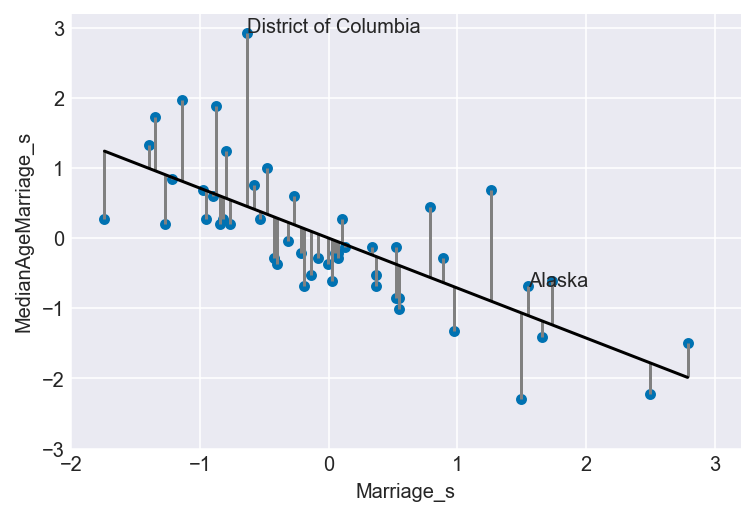

In [394]:
idx = np.argsort(d.Marriage_s)
d.plot('Marriage_s', 'MedianAgeMarriage_s', kind='scatter', xlim = (-2, 3.2), ylim = (-3, 3.2))
plt.plot(d.Marriage_s[idx], mu_pred_4_1[idx], 'k') # regression line of predicted marriage rate
plt.vlines(d.Marriage_s, mu_pred_4_1, mu_pred_4_1 + residuals_4_1, colors='grey')

plt.annotate(d.Location[8], (d.Marriage_s[8],d.MedianAgeMarriage_s[8]))
plt.annotate(d.Location[1], (d.Marriage_s[1],d.MedianAgeMarriage_s[1]));

Predicted Median Age of Marriage for DC and Alaska are lower than observed data. 

Also, we see that States with positive residuals have people that marry late in life for the State's rate of marriage. States with negative residuals marry young for their State's rate of marriage.

**Overlay residuals against linear regression**

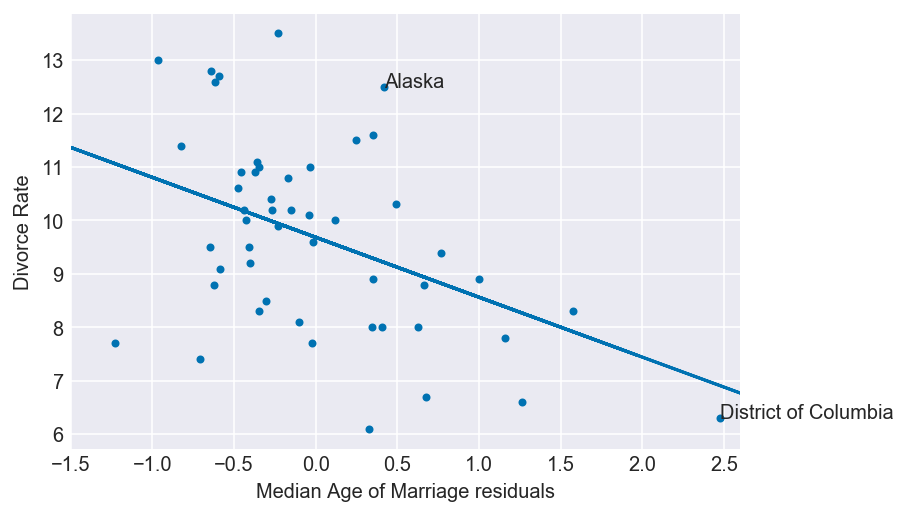

In [408]:
mu_pred_MarriageAge = trace_5_3['a'].mean() + trace_5_3['bA'][:,1].mean() * d.MedianAgeMarriage_s

plt.plot(residuals_4_1, d.Divorce, '.')

# Overlay the linear relationship between marriage age and Divorce, calculated from multivariate model
plt.plot(d.MedianAgeMarriage_s, mu_pred_MarriageAge, 'C0')
plt.xlabel("Median Age of Marriage residuals")
plt.ylabel("Divorce Rate")
plt.xlim(-1.5,2.6)
plt.annotate(d.Location[8], (residuals_4_1[8],d.Divorce[8]))
plt.annotate(d.Location[1], (residuals_4_1[1],d.Divorce[1]));

This plot displays the linear relationship between divorce and Median Age of Marriage, having statistically controlled for Marriage Rate. The regression line's slope is -1.12, exactly as computed in the multivariate model. Ini addition, we see that States in which people marry older than expected (to the right of zero), for a given rate of marriage, tend to have less divorce. States that marry earlier than expected (left of zero), tend to have higher divorce rates.

#### Summary:

We've identified that there is a spuriuos relationship between Marriage Rate and Divorce by using it as a predictor in a multivariate regression, where Median Age of Marriage is another predictor. Once Median Age of Marriage is known, knowing Marriage Rate gives little additional value in predicting fluctuations in Divorce. 

### Counterfactual Plots:

These plots ilustrate how the predictions change as you change only one predictor at a time. This means holding the values of all predictors constant, except for a single predictor of interest. Such predictions will not necessarily look like your raw data -- they are counterfactual after all -- but they help you understand the implications of the multivariate regression model.

**5.9**

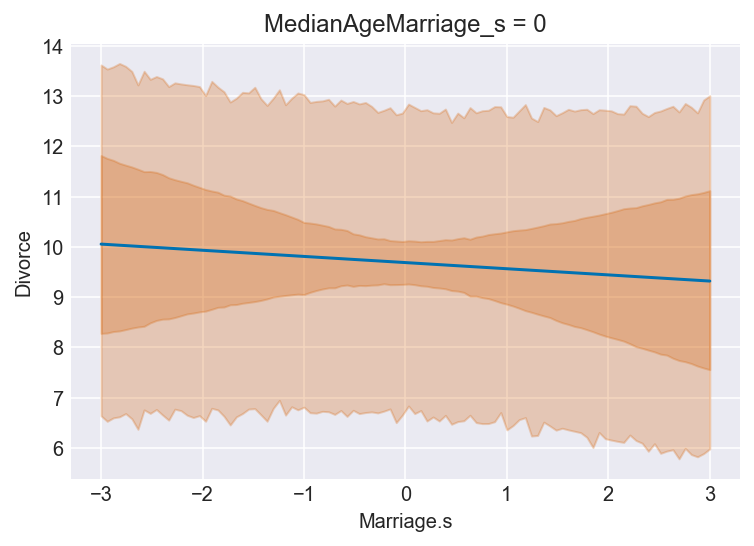

In [267]:
# We hold median age of marriage constant to view how predictions change as the marriage rate changes

R_avg = np.linspace(-3, 3, 100) # we are creating a linespace because we want counterfactual data

# ['bA'][:,0] is the parameter 4 marriage rate
mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,0] * R_avg[:,None] 
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('Marriage.s')
plt.ylabel('Divorce')
plt.title('MedianAgeMarriage_s = 0');

Above, we see the rate of change in divorce (-0.12) based on changes in Marriage Rate, while median age of marriage  value remains constant at 0.

**5.10**

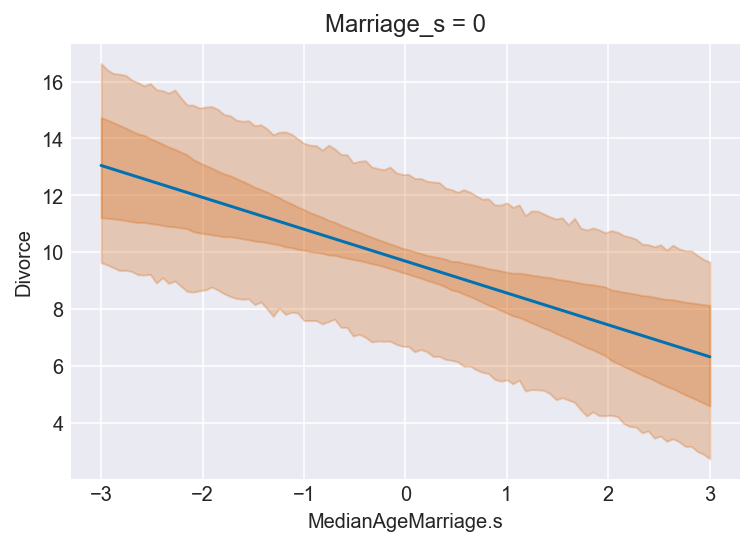

In [112]:
# We hold marriage rate constant to view how predictions change as the median age of marriage changes
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,1] * R_avg[:,None] 
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)


plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('MedianAgeMarriage.s')
plt.ylabel('Divorce')
plt.title('Marriage_s = 0');

Above, we see the rate of change in divorce (-1.12) based on changes in Median Age of Marriage, while Marriage Rate value remains constant at 0.

One critic with counterfactual plots is that they are not good at representing real world scenarios because they suppose a change in one predictor, while keeping the other constant. For example, it would be very hard to convince people to get married at a later age, while not impacting the marriage rate. The fact that people are asked to get married later in life would mean some might die before marriage, thus, affecting marriage rate.

### Posterior Prediction Plots

The goal here is to check the model fit against the observed data because it helps ilustrate where the:
1. model might not have fitted the data correctly
2. model fails (error in predictions)

**5.11**

In [362]:
# 97% interval of the mean
mu_pred_3 = trace_5_3['mu']
mu_hpd_3 = pm.hpd(mu_pred_3, alpha=0.05)

# 97% prediction interval
divorce_pred_3 = pm.sample_ppc(trace_5_3, samples=1000, model=model_5_3)['Divorce'] # simulate predictions
divorce_hpd = pm.hpd(divorce_pred_3)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 924.02it/s]


**5.12**

In [413]:
d.Divorce.min()

6.1

Note: the dashed line shows perfect prediction


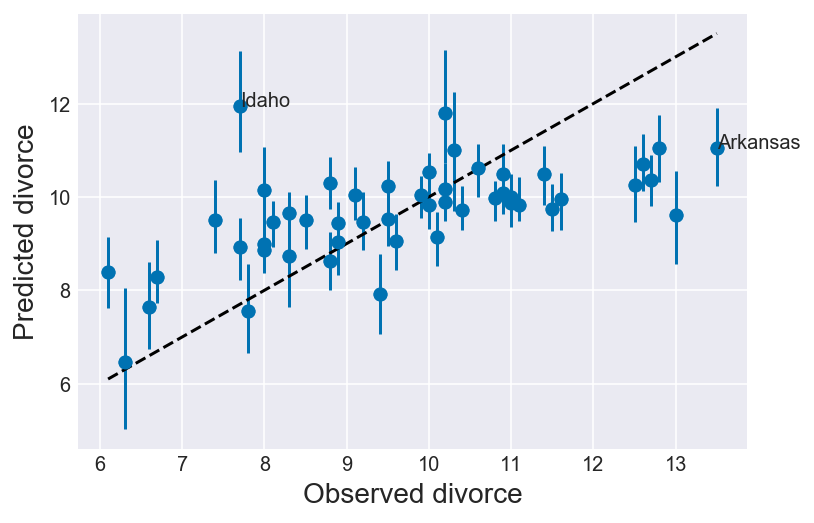

In [423]:
plt.plot(d.Divorce, divorce_pred_3.mean(0), 'C0o') # observed divorce data vs. fitted data from model
plt.errorbar(d.Divorce, divorce_pred_3.mean(0), yerr=np.abs(divorce_pred_3.mean(0)-mu_hpd_3.T) , fmt='C0o')

plt.xlabel('Observed divorce', fontsize=14)
plt.ylabel('Predicted divorce', fontsize=14)

min_x, max_x = d.Divorce.min(), d.Divorce.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--') 
plt.annotate(d.Location[3], (d.Divorce[3],divorce_pred_3.mean(0)[3]))
plt.annotate(d.Location[12], (d.Divorce[12],divorce_pred_3.mean(0)[12]));
print("Note: the dashed line shows perfect prediction")

**Where the model fails?**

States with high observed divorce rates are underpredicted by the model, while States with low divorce rates are overpredicted by our multivariate model.

**5.14**

Stronger visualization of the amount of prediction error (between predicted and observed divorce rate, based on the multivariate regression) for each State. 

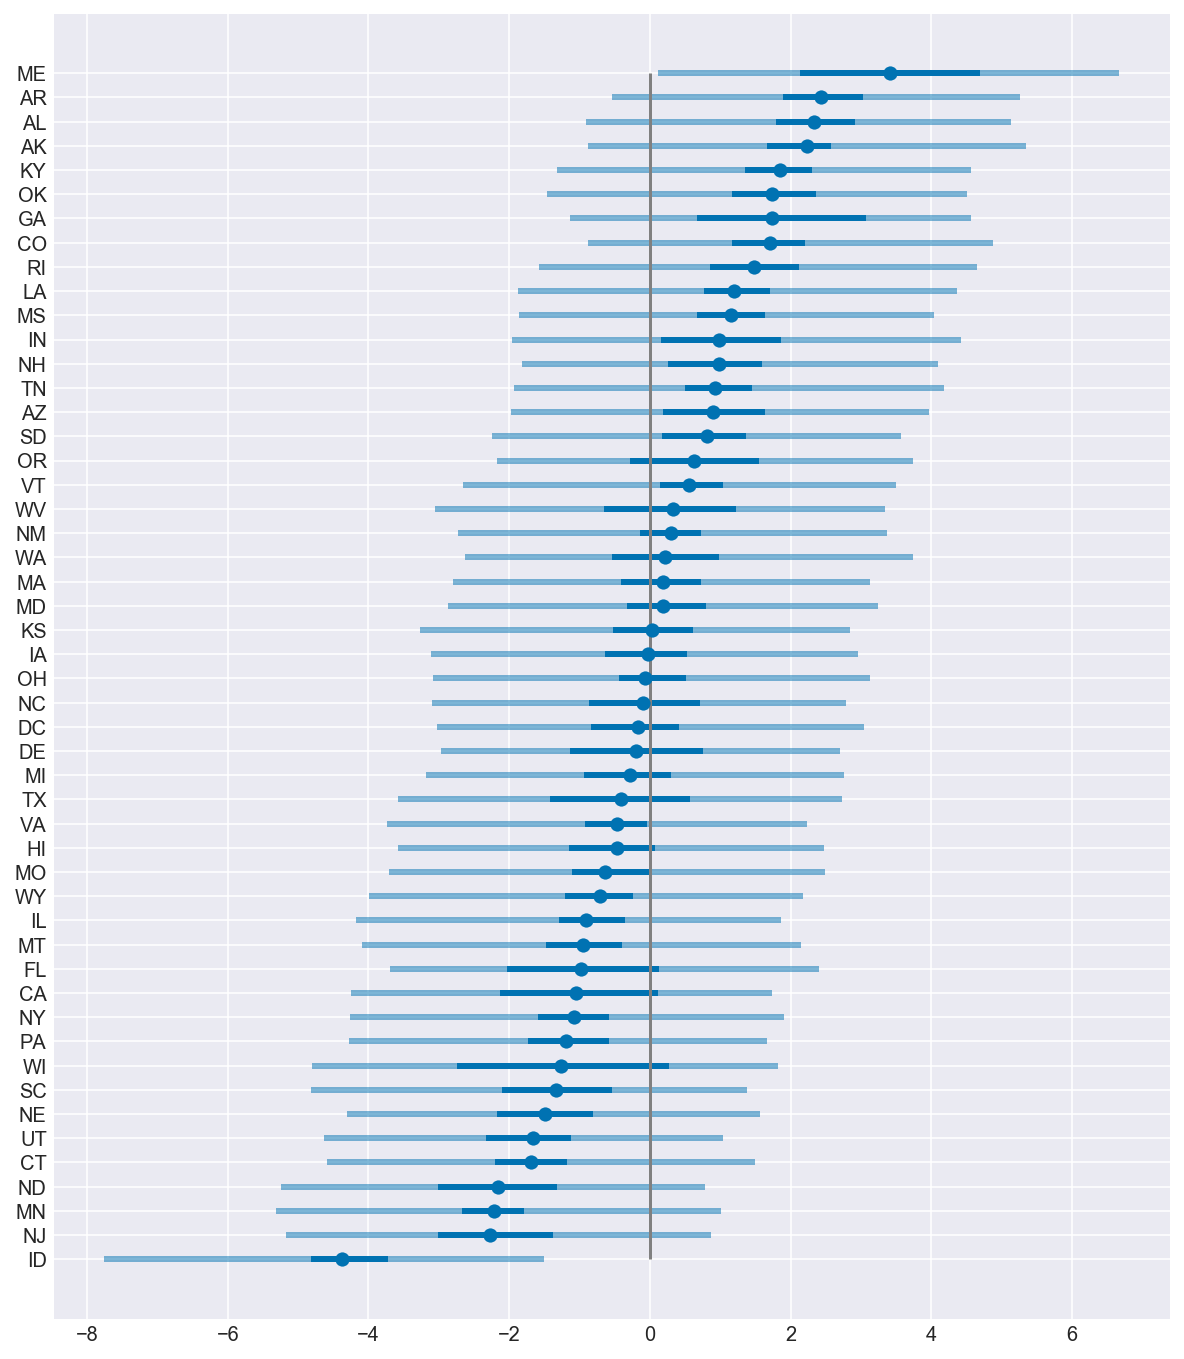

In [201]:
plt.figure(figsize=(10,12))
residuals = d.Divorce - mu_pred_3.mean(0)
idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, 1, 50)
plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred_3.mean(0)-mu_hpd_3.T),
             fmt='C0o',lw=3)

plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred_3.mean(0)-divorce_hpd.T),
             fmt='C0o', lw=3, alpha=0.5)

plt.yticks(y_points, y_label);
plt.vlines(0, 0, 1, 'grey');

We see that our multivariate model (where age of marriage and marriage rate are predictors of divorce) has a few states that have significant residuals. More precisely, our model underpredicted the divorce rates (to the right of the zero bar) or overpredicted them (left of bar). (the dark blue line shows 97% interval of the mean; the light blue shows 97% prediction interval.)

**Summary:**

Our multivariate model makes prediction errors (divorce residuals) where States have divorce rates that are either really high or really low. Maybe if we added more predictors, our model would make fewer errors.

# -------------------------------------------------------------------------------------------------------------

# Masked Relationship
When you have multiple factors whose influence on an outcome is not apparent through a bivariate relationship, a multivariate relationship could help measure those influences. Sometimes these factors' influences are not apparent because they are masked: They are predictor variables that are correlated with one anoter; and one of them is positively correlated with the outcome, while the other is negatively correlated with the outcome.

In [68]:
df = pd.read_csv('Data/milk.txt', sep=';')
print("*kcal.per.g: Kilocalories of energy per gram of milk. \n*mass: Average female body mass in kilograms. \n\
*neocortex.perc: The percent of total brain mass that is neocortex mass.")
df.head()


*kcal.per.g: Kilocalories of energy per gram of milk. 
*mass: Average female body mass in kilograms. 
*neocortex.perc: The percent of total brain mass that is neocortex mass.


clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

In [69]:
dcc = df.copy()
dcc['log_mass'] = np.log(dcc['mass'])

The correlation between Neocortex.perct and female body mass:

0.7503757903382418
The two preditors are positively correlated.


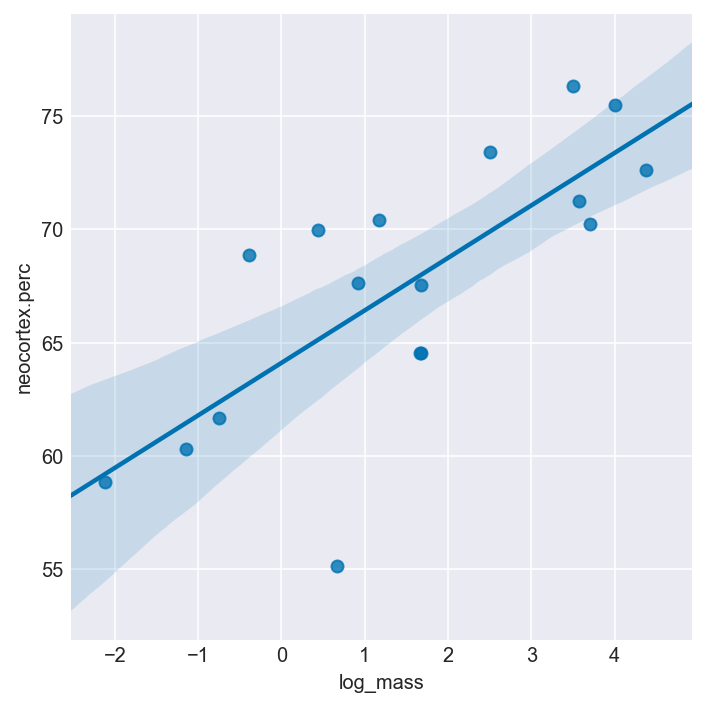

In [70]:
sns.lmplot(x='log_mass',y='neocortex.perc', data=dcc)
print(dcc['neocortex.perc'].corr(np.log(dcc['mass'])))
print("The two preditors are positively correlated.")

**The Question: To what extent energy content of milk (outcome) is related to neocortex.perc (predictor)?**

**5.17 to 5.20**

In [71]:
dcc = df.dropna().copy() # drop empty rows so the model doesn't malfunction.

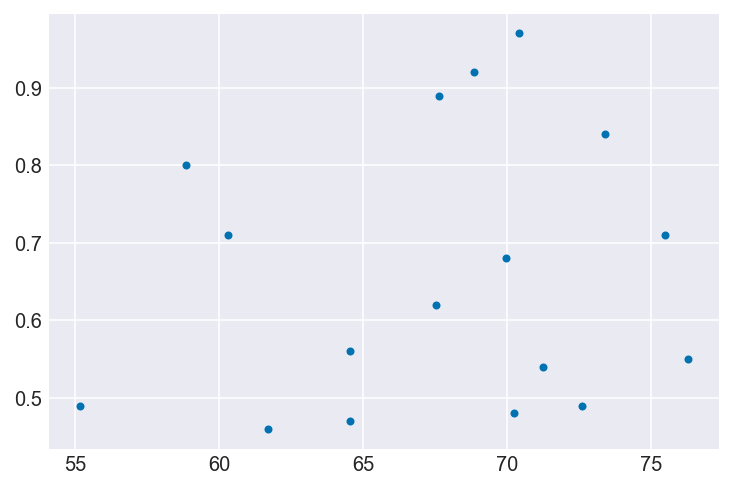

In [72]:
plt.plot(dcc["neocortex.perc"], dcc["kcal.per.g"], '.');

In [73]:
with pm.Model() as model_5_5:
    a = pm.Normal("a", 0,100)
    bn = pm.Normal("bn",0,1)
    sigma = pm.Uniform("sigma",0,1)
    mu = pm.Deterministic("mu",a+bn*dcc["neocortex.perc"])
    kcal = pm.Normal("kcal",mu=mu,sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_5 = pm.sample(3000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:58<00:00, 172.14draws/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7026988876374961, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


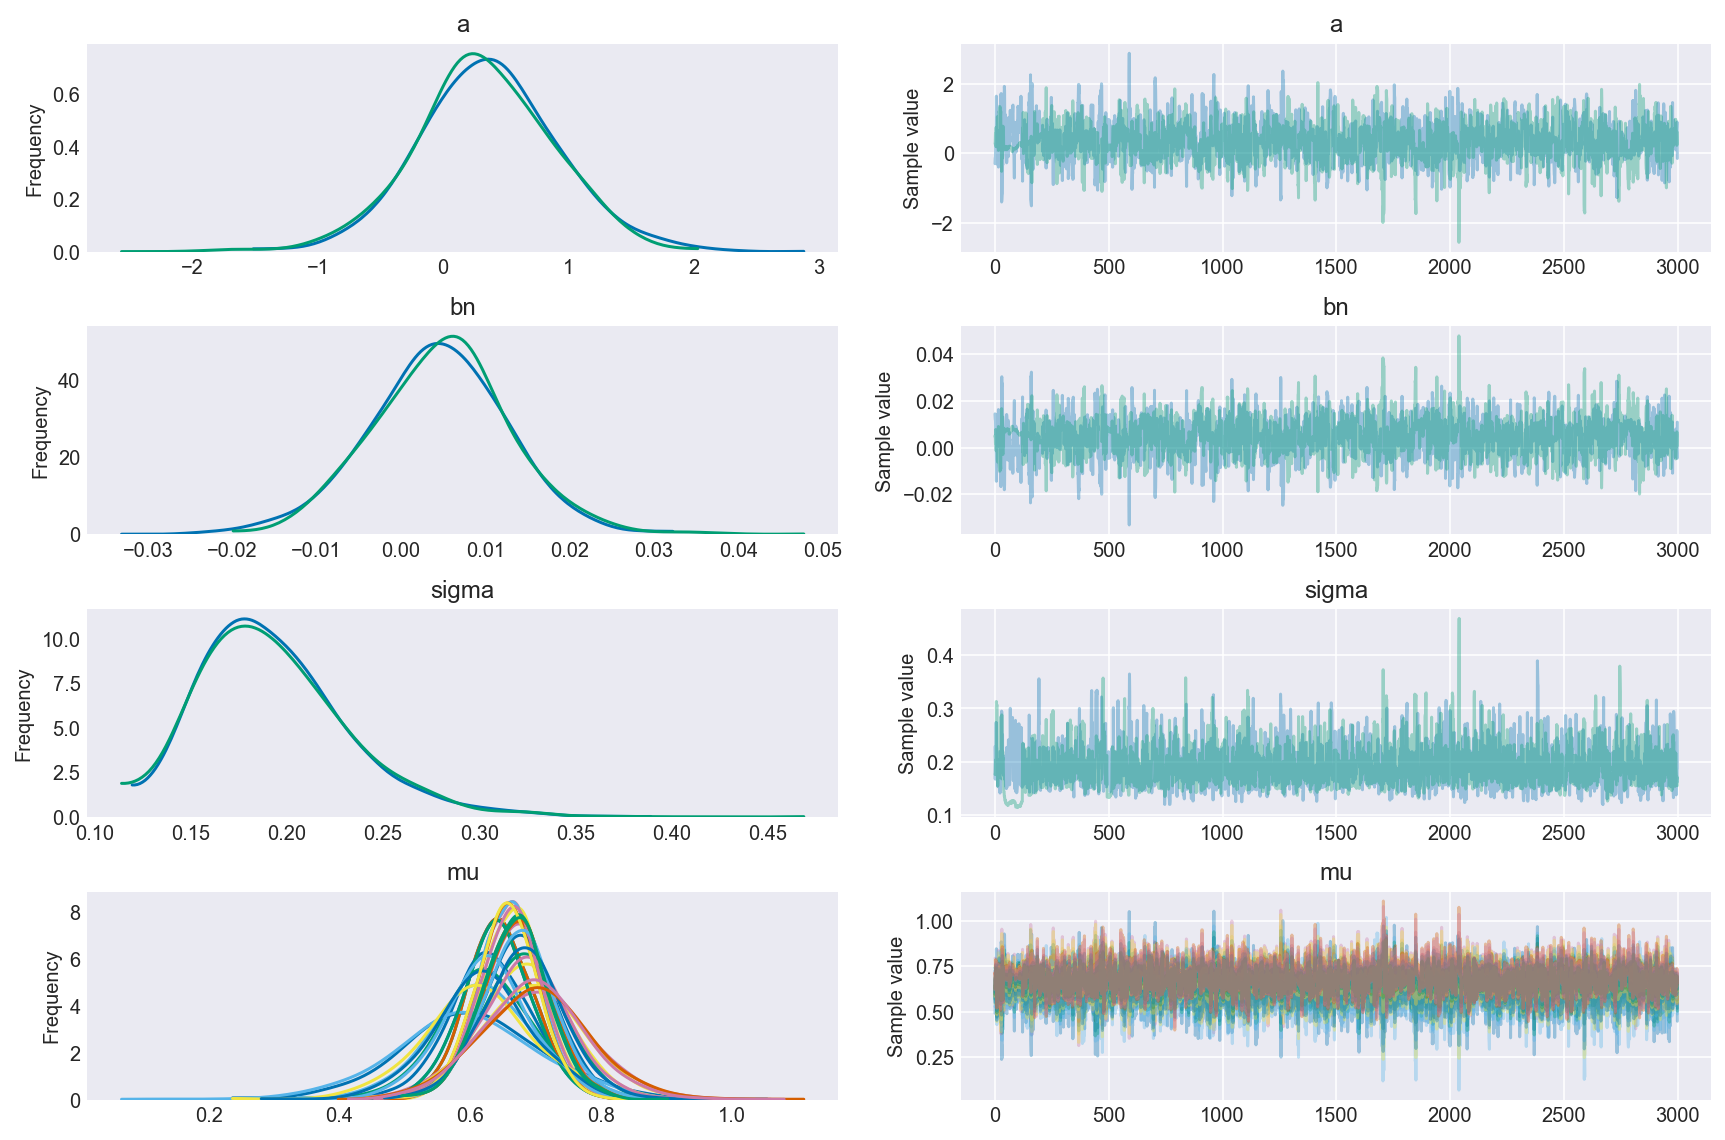

In [74]:
pm.traceplot(trace_5_5);

**5.21**

In [75]:
varnames = ['a', 'bn', 'sigma']
pm.summary(trace_5_5, varnames).round(3)

mean     sd  mc_error  hpd_2.5  hpd_97.5     n_eff   Rhat
a      0.344  0.552     0.014   -0.758     1.433  1260.994  1.002
bn     0.005  0.008     0.000   -0.012     0.020  1275.360  1.002
sigma  0.193  0.038     0.001    0.125     0.271  1058.222  1.000

**5.22**

In [76]:
print("A change from the smallest neocortex to the largest would result in an expected change of only")

print((trace_5_5['bn'].mean() * (dcc["neocortex.perc"].max() - dcc["neocortex.perc"].min())).round(3))

print("This change in the kcal of milk is insignificant, considering that the kcal range from 0.55-0.98")

A change from the smallest neocortex to the largest would result in an expected change of only
0.098
This change in the kcal of milk is insignificant, considering that the kcal range from 0.55-0.98


**5.23**
Counterfactual plot

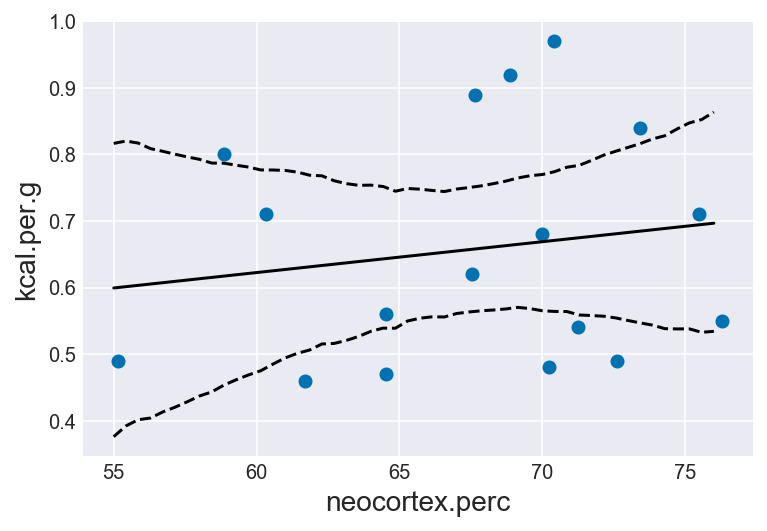

In [77]:
seq = np.linspace(55, 76, 50) # 55 and 76 are min and max of neocortex.prcnt
mu_pred = trace_5_5['a'] + trace_5_5['bn'] * seq[:,None]
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(dcc['neocortex.perc'], dcc['kcal.per.g'], 'C0o')

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc', fontsize=14)
plt.ylabel('kcal.per.g', fontsize=14);

We see that the regression line is slightly positive (bn=0.004), but from the 97% of the mean, we see that the regression line can also be negative; thus, the correlation is positive but very weak.

**The Question: To what extent energy content of milk (outcome) is related to the log of female body mass (predictor)?**

In [78]:
dcc['log_mass'] = np.log(dcc['mass'])

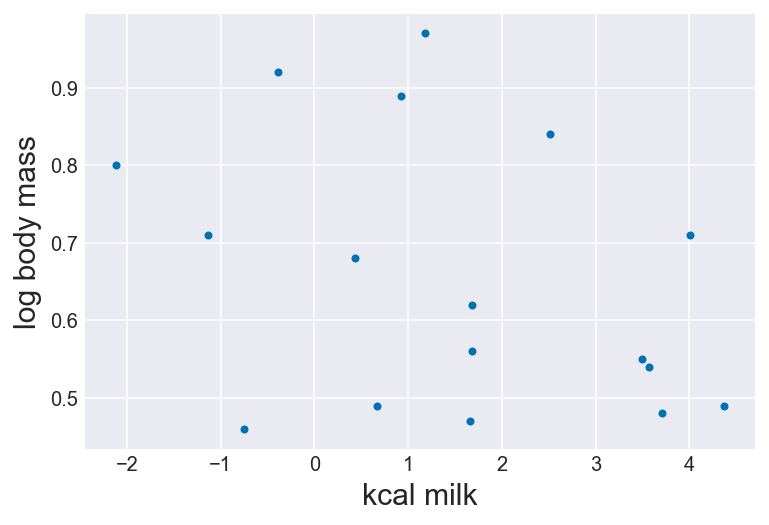

In [79]:
plt.plot(dcc['log_mass'], dcc['kcal.per.g'], '.')
plt.xlabel("kcal milk", fontsize=15)
plt.ylabel("log body mass", fontsize=15);

**5.25**

In [80]:
with pm.Model() as model_5_6:
    a = pm.Normal("a", 0,100)
    bn = pm.Normal("bn",0,1)
    sigma = pm.Uniform("sigma",0,1)
    mu = pm.Deterministic("mu",a + bn * dcc["log_mass"])
    kcal = pm.Normal("kcal",mu=mu,sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_6 = pm.sample(3000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.01draws/s]


In [81]:
pm.summary(trace_5_6, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      0.708  0.059     0.001    0.619     0.805  3264.033   1.0
bn    -0.032  0.025     0.000   -0.071     0.006  3386.870   1.0
sigma  0.183  0.038     0.001    0.129     0.238  2793.678   1.0

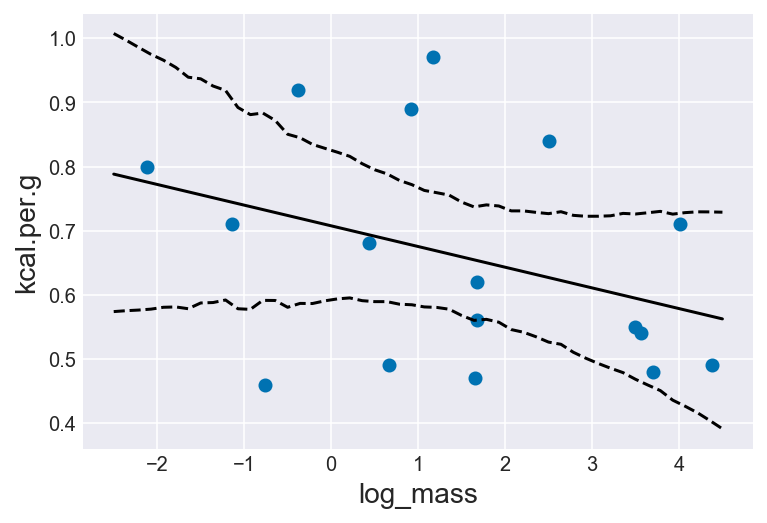

In [82]:
seq_6 = np.linspace(-2.5, 4.5, 50) # -2.5 and 4. 5are min and max of female body mass (log)
mu_pred_6 = trace_5_6['a'] + trace_5_6['bn'] * seq_6[:,None]
mu_hpd_6 = pm.hpd(mu_pred_6.T)

plt.plot(dcc['log_mass'], dcc['kcal.per.g'], 'C0o')

plt.plot(seq_6, mu_pred_6.mean(1), 'k')
plt.plot(seq_6, mu_hpd_6[:,0], 'k--')
plt.plot(seq_6, mu_hpd_6[:,1], 'k--')

plt.xlabel('log_mass', fontsize=14)
plt.ylabel('kcal.per.g', fontsize=14);

The regression slope between log body mass and energy of milk is negative, although when taking the 89% mean interval, there is a slight change it could be positive. Thus, just like neocortex.prct, the correlation is weak but it exists. As opposed to neocortex.prct's positive slope, this slope is slightly negative.

**5.26**

Let's create a multivariate regression using both predictors in the model to predict outcome of milk energy levels.

\begin{aligned}
Milk_i &\sim Normal(μ_i,σ)\\
μ_i &= α+β_NNeocortx_i+β_MLogMass_i\\
α &\sim Normal(1,10)\\
β_N &\sim Normal(0,1)\\
β_M &\sim Normal(0,1)\\
σ &\sim Uniform(0,1)
\end{aligned}

In [83]:
with pm.Model() as model_5_7:
    a = pm.Normal('a', mu=0, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=0.5)
    mu = pm.Deterministic('mu', a + bn[0] * dcc['neocortex.perc'] + bn[1] * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_7 = pm.sample(4000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 12000/12000 [01:43<00:00, 115.39draws/s]
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [84]:
pm.summary(trace_5_7, varnames, alpha=0.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a     -1.069  0.604     0.015   -1.982    -0.087  1794.073  1.003
bn__0  0.028  0.009     0.000    0.013     0.042  1770.858  1.003
bn__1 -0.096  0.029     0.001   -0.139    -0.048  2238.355  1.003
sigma  0.141  0.031     0.001    0.096     0.185  1077.515  1.000

**Summary:**

By incorportaing both predictors, the estimated association of both predictors with the outcome has increased. The posterior mean for the association of neocortex percent has increased sixfold (0.004 to 0.027), and the posterior mean for the association of log body mass has tripled (-0.031 to -0.095). The 89% posterior mean intervals for both predictors are either entirely above or entirely below zero now. Even the model residual (sigma) is smaller here than in the bivariate regressions (0.018 to 0.014). A lower model residual means that the variable x explains more of the variation in y; there's less uncertainty.

## Visualizing results
**5.27: Draw a counterfactual plot, depicting the relationship between milk energy and neocortex.**

Sidenote: Counterfactual plots ilustrate how the predictions change as you change only one predictor at a time. Therefore, we will use the mean log body mass, showing only how predicted energy varies as a function of neocortex.

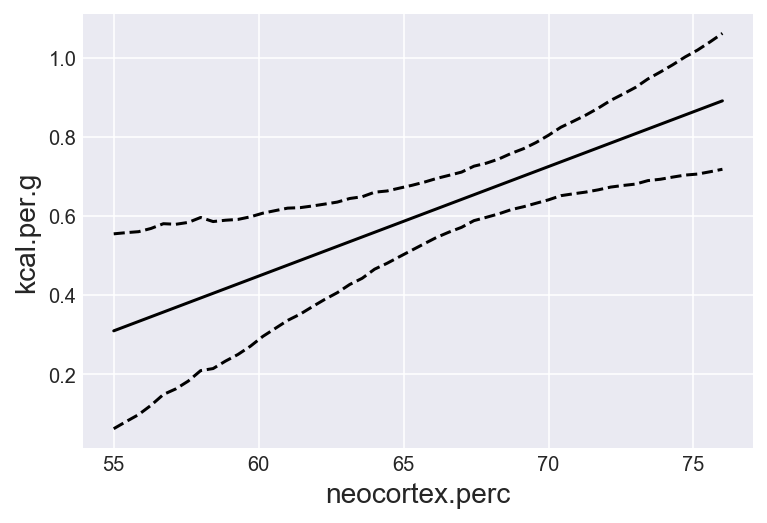

In [85]:
seq =  np.linspace(55, 76, 50)
mu_pred_7 = trace_5_7['a'] + trace_5_7['bn'][:,0] * seq[:,None] + trace_5_7['bn'][:,1] * dcc['log_mass'].mean()
mu_hpd_7 = pm.hpd(mu_pred_7.T) #use .T to reshape the array for hpd calculation purposes

plt.plot(seq, mu_pred_7.mean(1), 'k')
plt.plot(seq, mu_hpd_7[:,0], 'k--')
plt.plot(seq, mu_hpd_7[:,1], 'k--')

plt.xlabel('neocortex.perc', fontsize=14)
plt.ylabel('kcal.per.g', fontsize=14);

The slope describing the association between neocortex and milk energy is completely positive, roughly around 0.028. Let's use counterfactual plot to plot the the relationship between milk energy and log body mass.

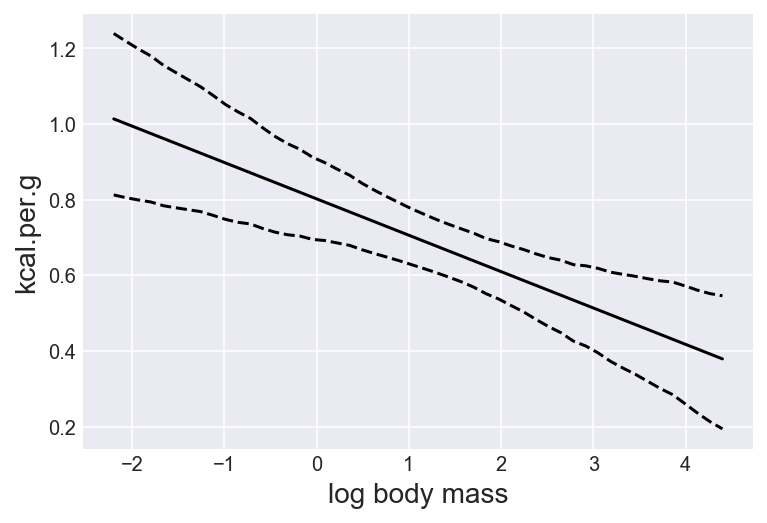

In [628]:
seq =  np.linspace(-2.2, 4.4, 50) # -2.2 and 4.4 are the min and max values of log body mass 
mu_pred_7_mass = trace_5_7['a'] + trace_5_7['bn'][:,0] * dcc['neocortex.perc'].mean() \
+ trace_5_7['bn'][:,1] * seq[:,None]

mu_hpd_7_mass = pm.hpd(mu_pred_7_mass.T) #use .T to reshape the array for hpd calculation purposes

plt.plot(seq, mu_pred_7_mass.mean(1), 'k')
plt.plot(seq, mu_hpd_7_mass[:,0], 'k--')
plt.plot(seq, mu_hpd_7_mass[:,1], 'k--')

plt.xlabel('log body mass', fontsize=14)
plt.ylabel('kcal.per.g', fontsize=14);

This relationship is entirely negative with a slope roughly around -0.096. 

**Summary:**
When two predictors are positively correlated with one another, and they are both correlated with the outcome (one positively, the other negatively), they mask each other out. That is why their association with the outcome would be stronger when used together in the same multivariate regression, as opposed to separate bivariate regressions.

### What the multivariate regression asks very well is: do species that have high neocortex percent (for their body mass) have higher milk energy? Oppositely, do species that have high body mass (for their neocortex percent) have higher milk energy?

Comparing the posterior prediction plots of the bivariate and multivariate model:

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 984.27it/s]


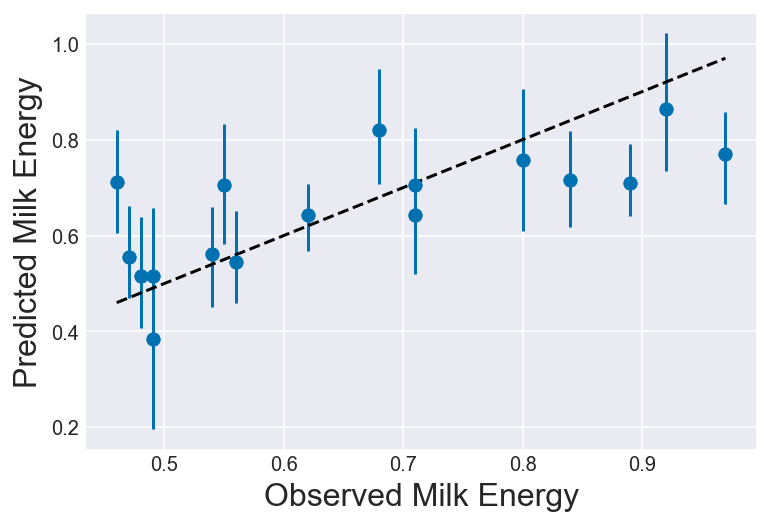

In [115]:
"""Multivariate Regression with log_body_mass and neocortex_percent as predictors"""
# 97% interval of the mean for Multivariate Regression
mu_pred_5_7= trace_5_7['mu']
mu_hpd_5_7 = pm.hpd(mu_pred_5_7, alpha=0.05)

# 97% prediction interval
kcal_pred_7 = pm.sample_ppc(trace_5_7, samples=1000, model=model_5_7)['kcal'] # simulate predictions
kcal_hpd = pm.hpd(kcal_pred_7)

# Plot Prediction plot
plt.plot(dcc['kcal.per.g'], kcal_pred_7.mean(0), 'C0o')
plt.errorbar(dcc['kcal.per.g'], kcal_pred_7.mean(0), yerr=np.abs(kcal_pred_7.mean(0)-mu_hpd_5_7.T) , fmt='C0o')

min_x, max_x = dcc['kcal.per.g'].min(), dcc['kcal.per.g'].max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--')
plt.xlabel("Observed Milk Energy", fontsize=16)
plt.ylabel("Predicted Milk Energy", fontsize=16); 

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1066.28it/s]


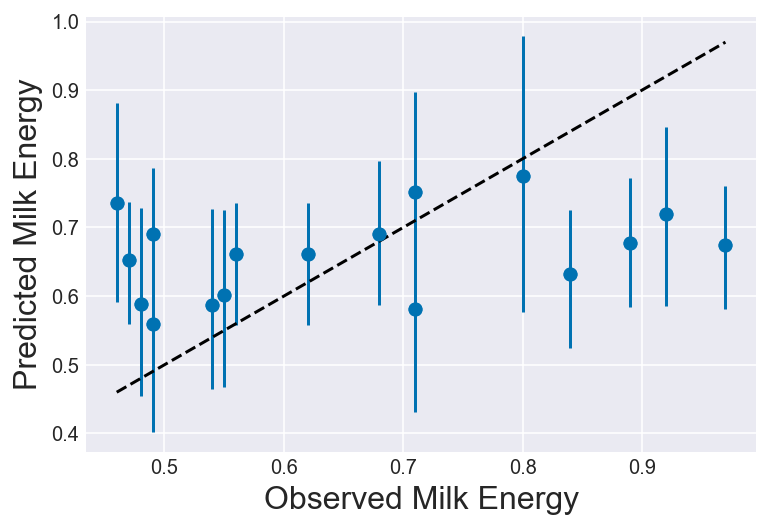

In [116]:
"""Bivariate Regression with log_body_mass as predictor"""
# 97% interval of the mean for Bivariate Regression
mu_pred_5_6= trace_5_6['mu']
mu_hpd_5_6 = pm.hpd(mu_pred_5_6, alpha=0.05)

# 97% prediction interval
kcal_pred_6 = pm.sample_ppc(trace_5_6, samples=1000, model=model_5_6)['kcal'] # simulate predictions
kcal_hpd_6 = pm.hpd(kcal_pred_6)

# Plot Prediction plot
plt.plot(dcc['kcal.per.g'], kcal_pred_6.mean(0), 'C0o')
plt.errorbar(dcc['kcal.per.g'], kcal_pred_6.mean(0), yerr=np.abs(kcal_pred_6.mean(0)-mu_hpd_5_6.T) , fmt='C0o')

min_x, max_x = dcc['kcal.per.g'].min(), dcc['kcal.per.g'].max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--')
plt.xlabel("Observed Milk Energy", fontsize=16)
plt.ylabel("Predicted Milk Energy", fontsize=16); 

**Summary:**

Comparing the two posterior prediction plots above, it's apparent that the multivariate model, which highlighted the masked relationship between neocortex and body mass, has smaller prediction errors than the bivariate model that only took body mass into consideration as a predictor of milk energy. 

# -------------------------------------------------------------------------------------------------------------

# When Adding Variables to Regression Hurts
* Multicollinearity
* Treatment Bias
* Overfitting

### Multicollinearity
We'll simulate a dataset with very high correlation between predictors. We'll do so by using simulated data of right and left legs as predictors of height. 

**5.29**

In [630]:
N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2) # simulated height with mean of 10
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.1) # simulated proportion of height for legs
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02) # simulated left leg measurement error
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)# right leg measurement error

Correlation between left and right leg

array([[1.        , 0.99953925],
       [0.99953925, 1.        ]])

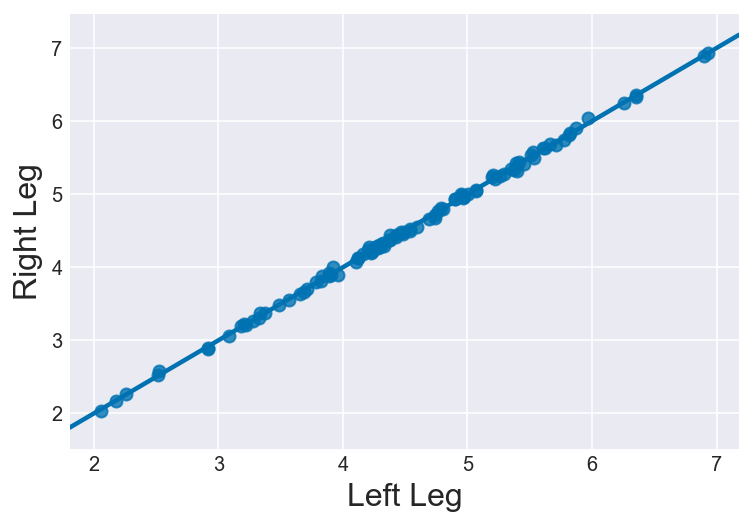

In [649]:
sns.regplot(leg_left, leg_right, data=None)
plt.xlabel("Left Leg", fontsize=16)
plt.ylabel("Right Leg", fontsize=16);

np.corrcoef(leg_right, leg_left)

As simulated and expected, there is a very high correlation between both legs of each person. Let's use both legs in multivariate model to see what happens.

**5.30**

In [631]:
with pm.Model() as m5_8:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)
    mu = pm.Deterministic('mu', a + bl * leg_left + br * leg_right)    
    sigma = pm.Uniform('sigma', lower=0 , upper=10)
    height_p = pm.Normal('height_p', mu=mu, sd=sigma, observed=height)
    
    trace_5_8 = pm.sample(3000, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, bl, a]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 9000/9000 [12:40<00:00,  5.81draws/s]


mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      0.724  0.289     0.005    0.247     1.164  3495.844  1.000
bl     1.031  1.999     0.037   -2.000     4.360  2416.899  1.001
br     1.053  1.998     0.037   -2.234     4.131  2425.664  1.001
sigma  0.623  0.045     0.001    0.552     0.692  3602.743  1.000

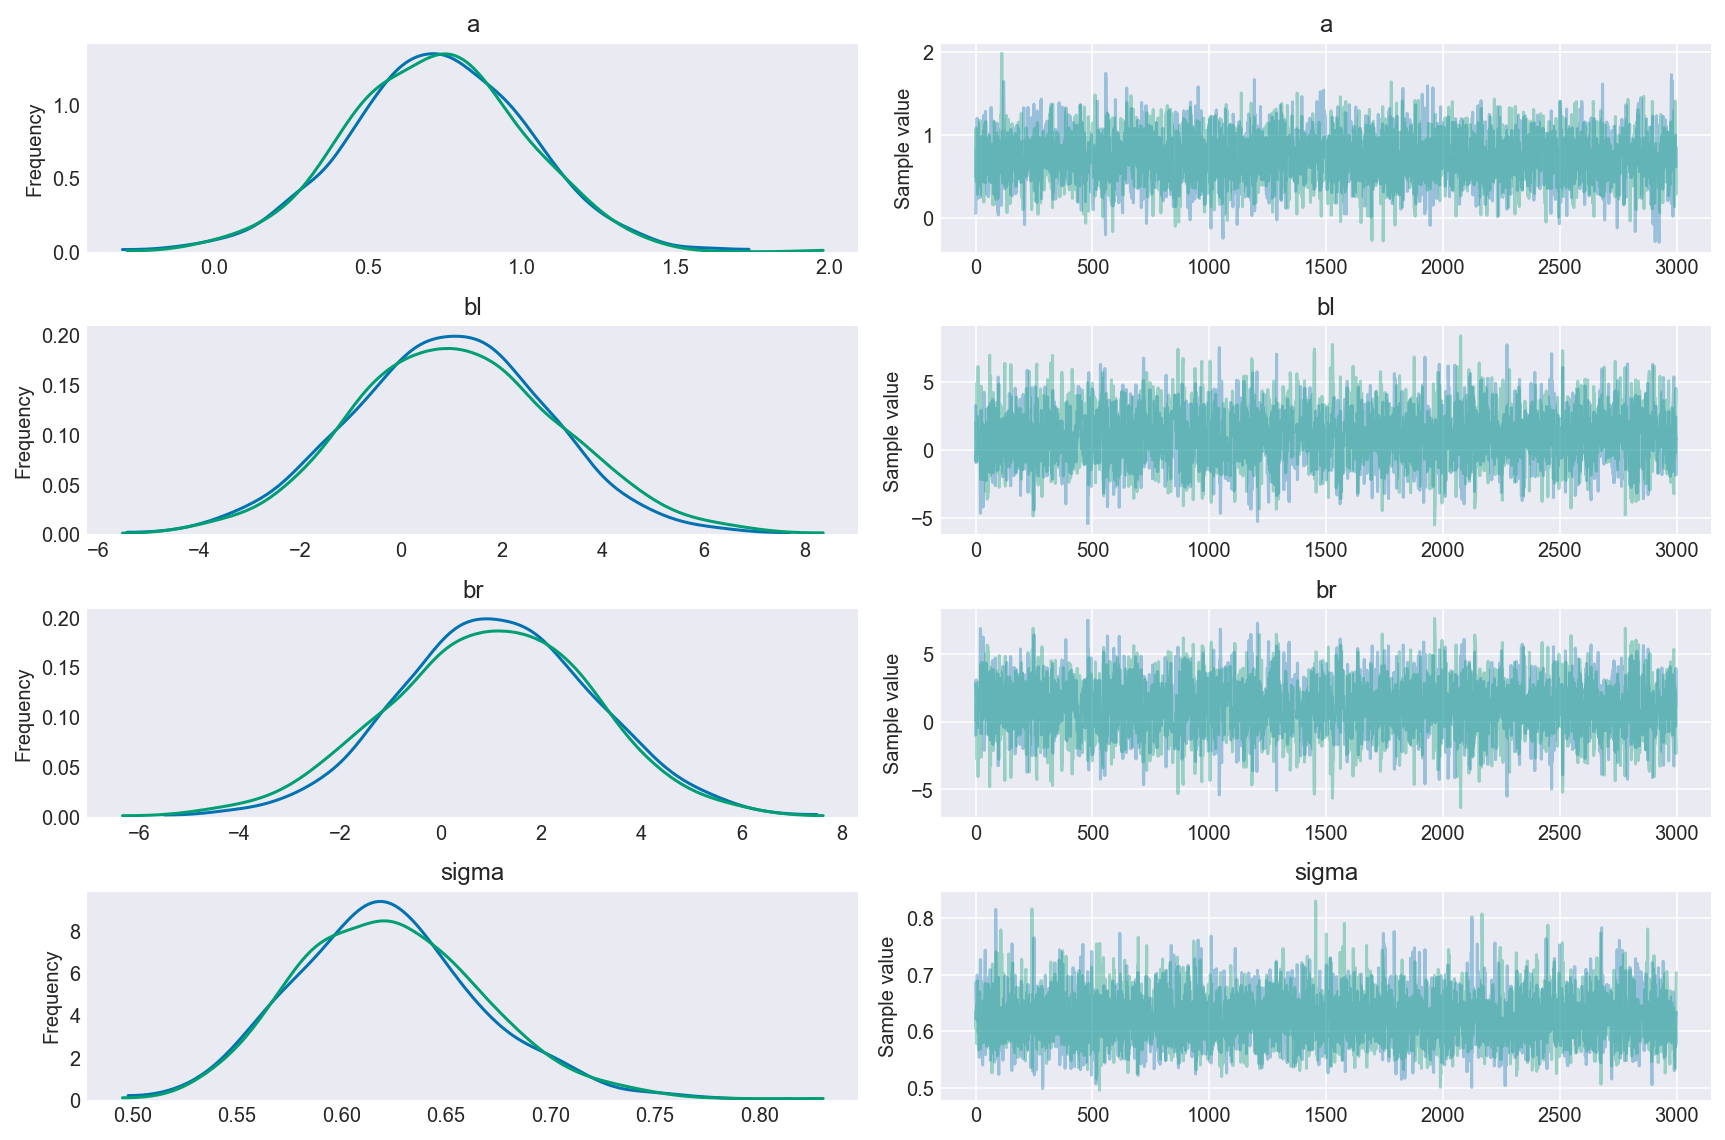

In [632]:
varnames=['a', 'bl', 'br', 'sigma']
pm.traceplot(trace_5_8, varnames);
pm.summary(trace_5_8, varnames, alpha=.11).round(3)

**5.31**

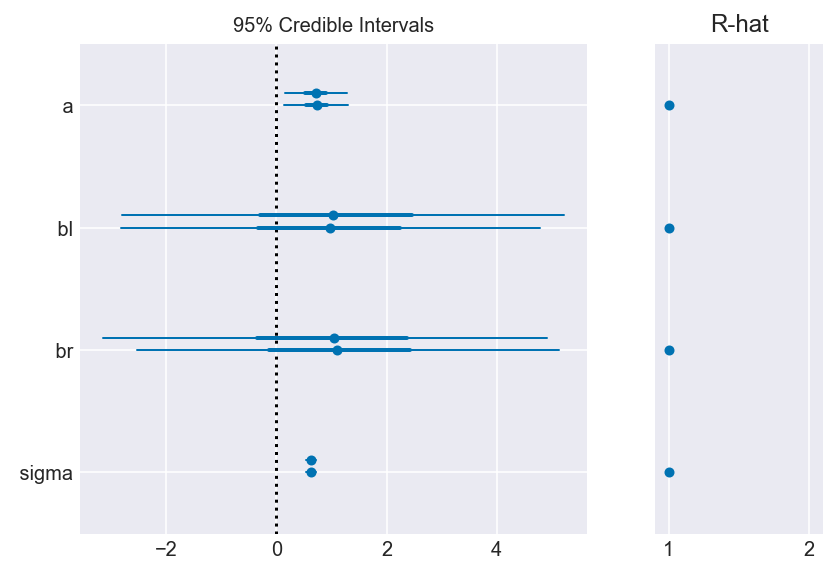

In [633]:
pm.forestplot(trace_5_8, varnames=varnames);

These posterior means and stadard deviations (model residuals represented by sigma) are crazy. The posterior mean 89% interval is telling us that the slopes of right and left legs are between -2 to 4, alleging a negative and positive relationship with the outcome. This doesn't make sense nor does it help us predcit height very well. 

Nonetheless, the model did fit correctly. And these posteriors are the correct answer to the multivariate regression question: 
* What is the value of knowing each predictor after already knowing all the other predictors?

The answer is: 
* Given that their information is almost exactly the same, the strength of one leg to predict the outcome would be very similar to the other leg's strength. In fact, there is practically an infinite number of combinations of right and left leg that produce the same predictions.

**5.32**

array([[ 1.        , -0.99951202],
       [-0.99951202,  1.        ]])

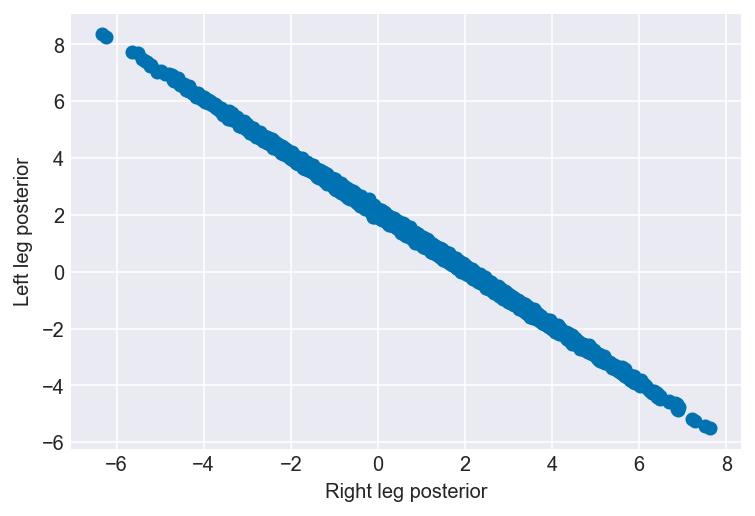

In [659]:
plt.scatter(trace_5_8['br'], trace_5_8['bl'])
plt.xlabel("Right leg posterior")
plt.ylabel("Left leg posterior");
np.corrcoef(trace_5_8['br'], trace_5_8['bl'])

The posterior distribution for the legs' parameters is very highly correlated. When right leg is large, left leg must be small, and vice versa. Given their high correlation, if the model knows the value of one predictor/leg, there is little additional benefit in knowing the value of the other predictor/leg.

In fact, given the extremely high correlation (over 0.9), it's as if we're asking the model to compute the same predictors (x):
\begin{aligned}
y_i &\sim Normal(μ_i,σ)\\
μ_i &= α+β_1X_i+β_2X_i
\end{aligned}
Which is the same as:
\begin{aligned}
y_i &\sim Normal(μ_i,σ)\\
μ_i &= α+(β_1+β_2)*X_i
\end{aligned}

The posterior distribution looks for all the different ways that the sum of (β_1+β_2) influences the association of x with y. But given that it's a sum, there are infinite combinations of β_1 and β_2 that produce the same predictions.

**5.33**

Let's visualize how the posterior distribution gives an estimate of the sum of br and bl.

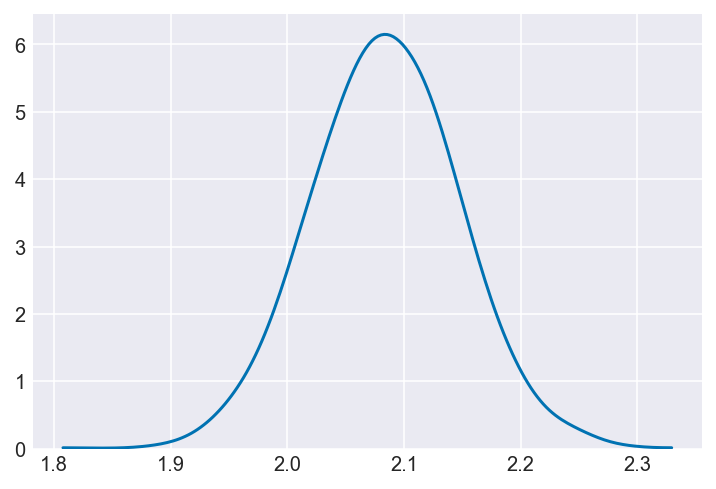

In [660]:
sum_blbr = trace_5_8['br'] + trace_5_8['bl']
pm.kdeplot(sum_blbr);

The posterior mean is slightly > 2, representing the sum of the slopes of both legs. Below, we will fit a regression with only one of the leg length variables, and see how we get the same posterior mean.

**5.34**

In [657]:
with pm.Model() as m5_9:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=height)
    trace_5_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:26<00:00, 149.28draws/s]
The acceptance probability does not match the target. It is 0.6593008650348656, but should be close to 0.8. Try to increase the number of tuning steps.


In [661]:
varnames_1 = ['a', 'bl', 'sigma']
#pm.traceplot(trace_5_9, varnames_1)
pm.summary(trace_5_9, varnames_1, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      0.735  0.301     0.009    0.243     1.190  807.616   1.0
bl     2.080  0.065     0.002    1.984     2.187  783.633   1.0
sigma  0.624  0.045     0.001    0.559     0.697  804.568   1.0

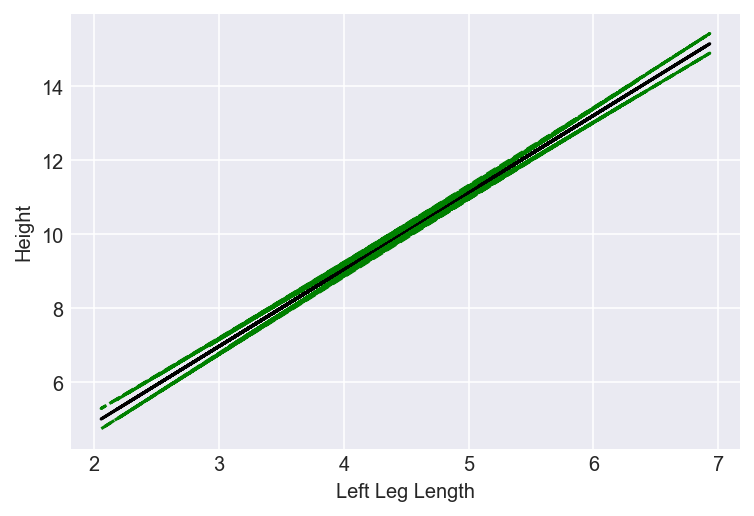

In [700]:
mu_pred_9 = trace_5_9['mu'] 
mu_hpd_9 = pm.hpd(mu_pred_9, alpha=0.11) 

plt.plot(leg_left, mu_pred_9.mean(0), 'k')
plt.plot(leg_left, mu_hpd_9[:,0], 'k--', c='green')
plt.plot(leg_left, mu_hpd_9[:,1], 'k--', c='green')
plt.xlabel("Left Leg Length")
plt.ylabel("Height");

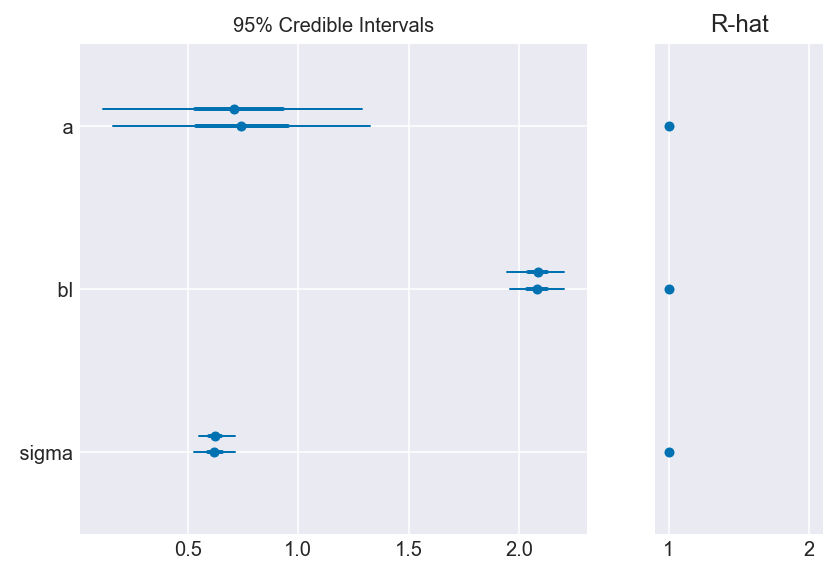

In [702]:
varnames=['a','bl','sigma']
pm.forestplot(trace_5_9, varnames=varnames);

**Summary:**

As expected, for every unit increase in left leg length there is a two-unit increase in height. 

When we used both legs as predictors in a multivariate regression, the rate of change was 1 for each leg and the 89% interval for the posterior mean was positive and negative (-2 to +4), due to the legs' high correlation (over 85%). But when we used only one leg as predictor the 89% interval for the posterior mean was completely positive, with high certainty (gree line).

To conclude, when two predictor variables are very strongly correlated, including both in a model may lead to confusion or mistakenly think that neither predictor is important. The posterior distribution isn't wrong; it's just telling you that the question you asked cannot be answered with these data. The latter bivariate regression model can give us great height prediction based on one of the legs, but it cannot tell us which leg is more important.  

## Milk Data in Multicollinearity
**5.35**

In [2]:
milk = pd.read_csv('Data/milk.txt', sep=';')
milk.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

Let's use the variables percent_lactose and percent_fat to model the total energy content of milk. We'll start by modeling each in separate bivariate regressions and make note of their slope and standar deviations of the slopes. 

Modeling **Percent_Fat** as predictor of milk energy

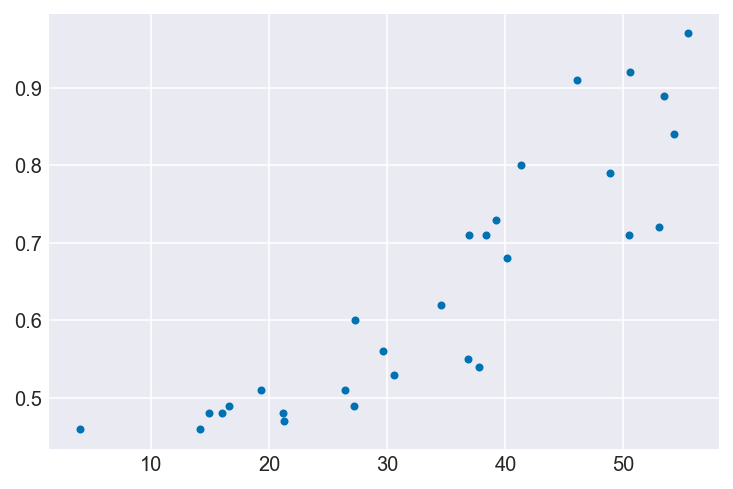

In [6]:
plt.plot(milk['perc.fat'], milk['kcal.per.g'], '.');

**5.36**

In [4]:
with pm.Model() as m5_10:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 1)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_10 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, a]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:34<00:00, 172.25draws/s]


Modeling **Percent_Lactose** as predictor of milk energy

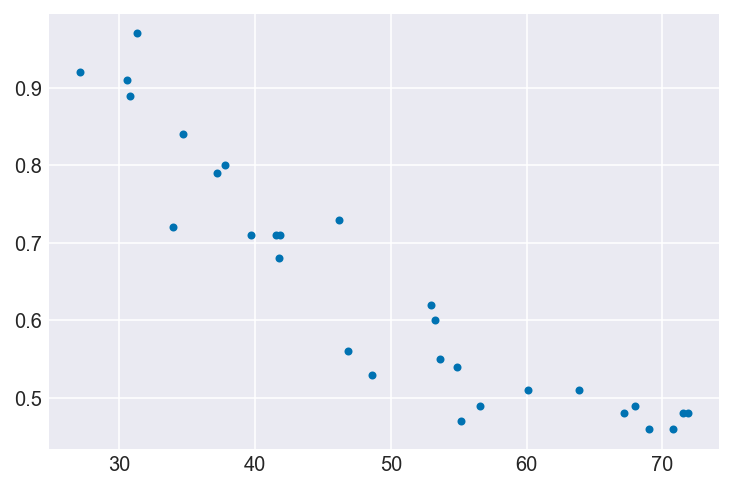

In [10]:
plt.plot(milk['perc.lactose'], milk['kcal.per.g'], '.');

In [47]:
with pm.Model() as m5_11:
    a = pm.Normal('a', mu=0.6, sd=10)
    bl = pm.Normal('bl', mu=0, sd=1)
    mu = pm.Deterministic('mu',a + bl * milk['perc.lactose'])
    sigma = pm.Uniform('sigma', lower=0, upper=5)
    kcalperg = pm.Normal('kcalperg', mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_11 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:32<00:00, 184.58draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6665572560576297, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [48]:
print("Fat to milk relationship")
varnames=['a','bf','sigma']
pm.summary(trace_5_10, varnames, alpha=.11).round(3)

Fat to milk relationship


mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      0.301  0.038     0.001    0.241     0.360  1496.240  1.001
bf     0.010  0.001     0.000    0.008     0.012  1572.676  1.001
sigma  0.080  0.011     0.000    0.063     0.098  1894.099  1.000

In [49]:
print("Lactose to milk relationship")
varnames = ['a', 'bl', 'sigma']
pm.summary(trace_5_11, varnames, alpha=.11).round(3)

Lactose to milk relationship


mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      1.168  0.046     0.001    1.100     1.244  1362.349  1.002
bl    -0.011  0.001     0.000   -0.012    -0.009  1415.247  1.002
sigma  0.067  0.010     0.000    0.052     0.082   979.261  1.000

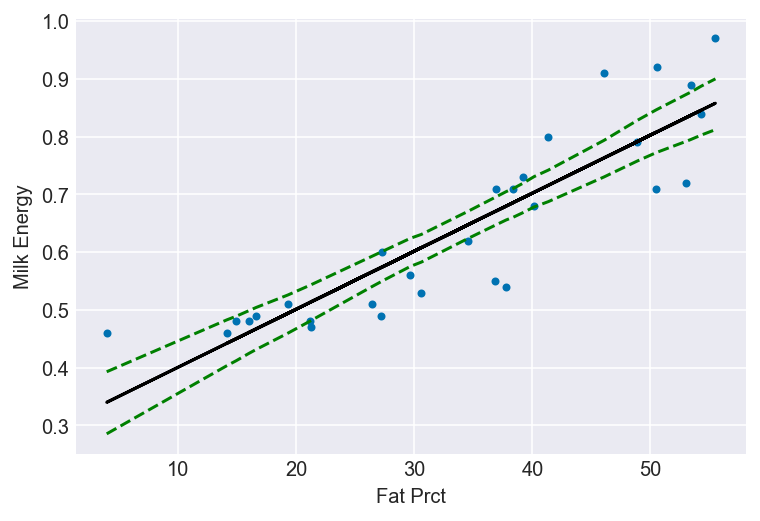

In [50]:
mu_pred_10 = trace_5_10['mu'] 
mu_hpd_10 = pm.hpd(mu_pred_10, alpha=0.11) 
idx = np.argsort(milk['perc.fat'])

plt.plot(milk['perc.fat'], milk['kcal.per.g'], '.')
plt.plot(milk['perc.fat'], mu_pred_10.mean(0), 'k')

plt.plot(milk['perc.fat'][idx], mu_hpd_10[:,0][idx], 'k--', c='green')
plt.plot(milk['perc.fat'][idx], mu_hpd_10[:,1][idx], 'k--', c='green')
plt.xlabel("Fat Prct")
plt.ylabel("Milk Energy");

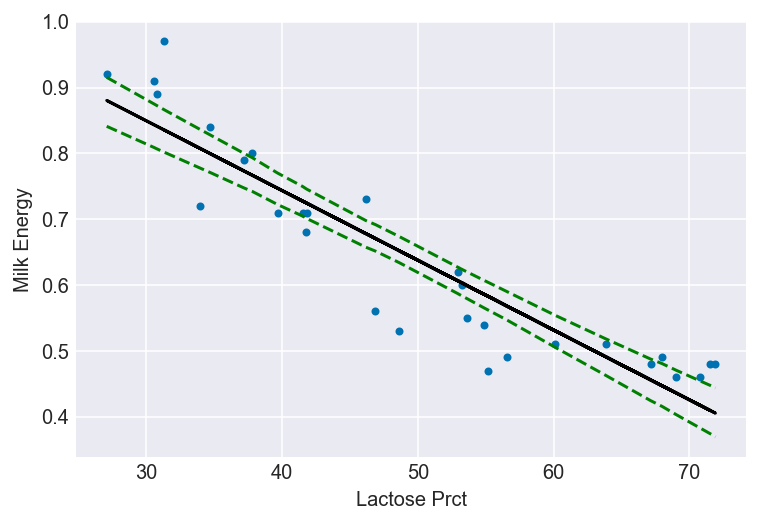

In [51]:
mu_pred_11 = trace_5_11['mu'] 
mu_hpd_11 = pm.hpd(mu_pred_11, alpha=0.11) 
idx = np.argsort(milk['perc.lactose'])

plt.plot(milk['perc.lactose'], milk['kcal.per.g'], '.')
plt.plot(milk['perc.lactose'], mu_pred_11.mean(0), 'k')
plt.plot(milk['perc.lactose'][idx], mu_hpd_11[:,0][idx], 'k--', c='green')
plt.plot(milk['perc.lactose'][idx], mu_hpd_11[:,1][idx], 'k--', c='green')
plt.xlabel("Lactose Prct")
plt.ylabel("Milk Energy");

When modeling the predictors to the outcome separately, we see that their slopes are a mirror image of one another (-0.01, +0.01). That is, lactose's influence on the change rate of milk energy is as positive as fat's influence on milk energy is negative.

**5.37**

Given the strong association of each predictor with the outcome, we might conclude that both variables are reliable predictors of milk energy, across species. The more fat, the more kilocalories in the milk; the more lactose, the fewer kilocalories in the milk. 

But let's see what happens when both predictors are part of the same multivariate regression model.

In [52]:
with pm.Model() as m5_12:
    a = pm.Normal('a', mu=0.6, sd=10)
    bf = pm.Normal('bf', mu=0, sd=1)
    bl = pm.Normal('bl', mu=0, sd=1)
    mu = pm.Deterministic('mu', a + bf*milk['perc.fat'] + bl*milk['perc.lactose'])
    sigma = pm.Uniform('sigma', lower=0, upper=5)
    kcalperg = pm.Normal('kcalperg', mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_12 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, bf, a]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:54<00:00, 110.56draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


In [53]:
varnames = ['a', 'bf', 'bl', 'sigma']
pm.summary(trace_5_12, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      1.010  0.221     0.007    0.667     1.370  1088.782   1.0
bf     0.002  0.003     0.000   -0.002     0.006  1108.389   1.0
bl    -0.009  0.003     0.000   -0.013    -0.005  1115.118   1.0
sigma  0.068  0.010     0.000    0.054     0.082  1446.464   1.0

We see that both posterior means are closer to zero and their sd has tripled. What happened? Given that percnt fat and percnt lactose contain much of the same information (see correlation below), they are substitutes for one another. As a result, when you include both in a regression, the posterior distribution ends up describing a long ridge of combinations of bf and bl that are equally plausible (just like with the leg length model).

**5.38 - 5.39**

Fat and Lactose are strongly correlated with each other.

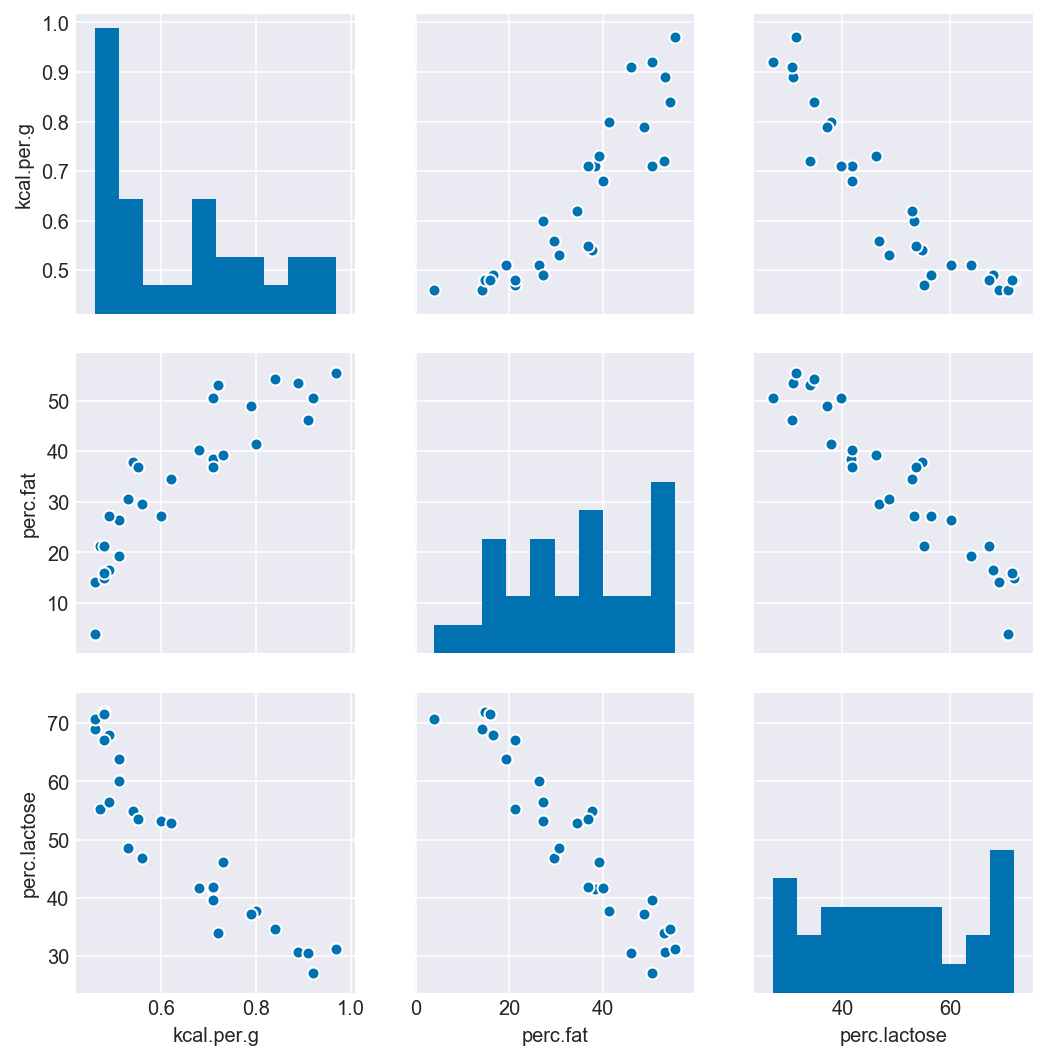

In [58]:
df = milk[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df);

In [64]:
milk.corr()['perc.fat']['perc.lactose']

-0.9416373456839282

The two predictors are so strongly correlated with one another that they are redundant in the same model. Either helps in predicting milk energy, but neither help much once you know the other.

**5.40**

Simulate increase in correlation between two variables to see its affect on the standard deviation.

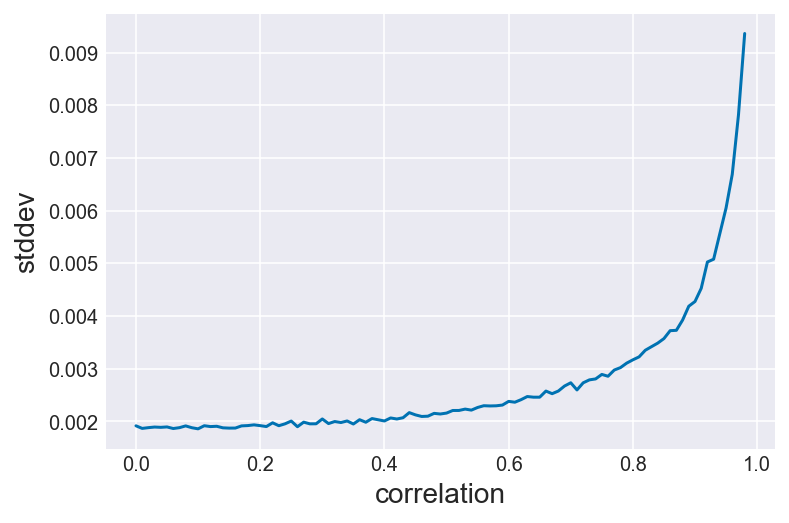

In [66]:
import statsmodels.formula.api as smf

def simcoll(r = 0.9):
    milk['x'] = stats.norm.rvs(size=len(milk), loc = r * milk['perc.fat'],
                       scale = np.sqrt((1 - r**2) * milk['perc.fat'].var()))
    X = np.column_stack((milk['perc.fat'], milk['x']))
    m = smf.OLS(milk['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation', fontsize=14)
plt.ylabel('stddev', fontsize=14);

**Summary:**

As the correlation bewteen two variables increases, the standard deviation increases. When there is low correlation the std remains fairly stable, but beyond 0.9 the std starts increasing exponentially. Therefore, you should be mindful of the affect of multicollinearity when correlation between two variables is above 0.9. 

OJO: It isn't always true that a pair of highly correlated variables are completely redundant -- other predictors might be correlated with only one of the pair, and so help extract the unique information each predictor provides. 

**Two good ways to anticipate multicollinearity:**
* draw a pairplot of your variables to identify any pair with very large correlations, roughly over 0.9
* look for big inflations of standard deviation (comparing the bivariate to the multivariate regression models) when both predictors are included in the same multivariate  model

## Post-treatment Bias
A phenomenon caused by including variables that are consequences of other variables in a multivariate model, which leads to mistaken inferences. For example, trying to measure the effect of sun screen strength on sun-burns (redness of skin) on equally sunny days, while including the post-treatment bias 'blisters' as a predictor. 

Blisters might be a stronger predictor than sun screen strength of redness of skin, but we are not interested in that question. Given that blisters are a consequence of (lack of) sun screen, and given that we want to make a casual inference about sun screen on redness of skin, we need to take blisters out of the model.  

**5.41**

Simulate toy data on predictors: fungus, initial plant height, and soil treatment, and outcome: final plant height

In [118]:
# number of plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(size = N, loc = 10, scale = 2)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = np.random.binomial(n=1, p=(0.5-treatment * 0.4), size=N)
h1 = h0 + stats.norm.rvs(size= N, loc= 5- 3*fungus, scale=1) # h1 is final height

# compose a clean data frame
d = pd.DataFrame({'h0': h0,
                  'h1': h1,
                  'Treatment':treatment,
                  'Fungus': fungus})

**5.42**

Fit a multivariate model that includes all predictors, even fungus which is a post-treatment variable

In [125]:
with pm.Model() as m5_13:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    bf = pm.Normal('bf',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment + bf * fungus)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed = d['h1'].get_values())
    trace_5_13 = pm.sample(3000, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, bt, bh, a]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 9000/9000 [00:45<00:00, 195.69draws/s]
The acceptance probability does not match the target. It is 0.8811300047710912, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909123754604487, but should be close to 0.8. Try to increase the number of tuning steps.


In [126]:
varnames = ['a', 'bh', 'bt', 'bf', 'sigma']
pm.summary(trace_5_13, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      5.026  0.562     0.011    4.127     5.913  2234.458  1.001
bh     1.004  0.051     0.001    0.925     1.088  2344.403  1.000
bt     0.225  0.240     0.004   -0.154     0.607  3116.753  1.001
bf    -3.007  0.262     0.005   -3.430    -2.586  3443.479  1.000
sigma  1.029  0.076     0.001    0.904     1.144  4657.359  1.000

**Summary**

We see that fungus has a much stronger association with the final height of plant. In fact, once fungus is known, there is little added value in knowing treatment type (the effect of treatment is very small). The problem is that fungus is mostly a consequence of treatment, and although the model did fit well because fungus does affect growth of plant, we asked another question: how does treatment affect growth?

To answer this question, we should omit the post-treatment variable fungus.

**5.43**

In [127]:
with pm.Model() as m5_14:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed =d['h1'])
    trace_5_14 = pm.sample(3000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bt, bh, a]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:44<00:00, 247.58draws/s]
The acceptance probability does not match the target. It is 0.8790264898794441, but should be close to 0.8. Try to increase the number of tuning steps.


In [128]:
varnames = ['a', 'bh', 'bt', 'sigma']
pm.summary(trace_5_14, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      3.846  0.861     0.020    2.511     5.252  1728.063  1.002
bh     0.957  0.079     0.002    0.829     1.080  1815.091  1.002
bt     1.638  0.322     0.005    1.150     2.174  3423.952  1.000
sigma  1.606  0.120     0.002    1.417     1.794  4207.151  1.000

**Summary:**

Now that we've taken the post-treatment variable (fungus) out of the model, the impact of treatment is strong and positive, as it should be.

Side note:
* Initial height might mask the casual inference of treatment, which is why it's important we added it to the model. Adding it actually helped reduce the final height prediction errors because now the model is asking and answering a better question: Do plants that have good treatment for their initial height, grow taller?  

# -------------------------------------------------------------------------------------------------------------


# Categorical Variables
* Binary categories
* Multiple categories

**5.44**

In [130]:
d = pd.read_csv('Data/Howell1.txt', sep=';')
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

## Binary categories

**How does gender help predict height?**

The male variable is our new predictor and an example of a Dummy Variable. When m_i=1 it will turn on the parameter β in the model. When m_i=0 it has no effect on prediction becuase it is multiplied by zero inside the linear model, α+β_mm_i, cancelling it out, whatever its value.

\begin{aligned}
h_i &\sim Normal(μ_i,σ)\\
μ_i &= α+β_mm_i\\
α &\sim Normal(178,100)\\
β_m &\sim Normal(0,10)\\
σ &\sim Uniform(0,50)
\end{aligned}

**5.45**

In [131]:
with pm.Model() as m5_15:
    a = pm.Normal('a',mu = 178, sd=100)
    bm = pm.Normal('bm',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bm * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15 = pm.sample(3000, tune=200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bm, a]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 6400/6400 [00:31<00:00, 202.21draws/s]
The acceptance probability does not match the target. It is 0.9248431377249589, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9028680228956146, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [132]:
varnames = ['a', 'bm', 'sigma']
pm.summary(trace_5_15, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      134.859  1.625     0.045  132.253   137.411  1549.706  1.001
bm       7.202  2.323     0.081    3.696    11.068   867.565  1.000
sigma   27.428  0.831     0.011   26.060    28.726  5914.675  1.000

To interpret these estimates you have to note that the paramete α(a) is now the average height among females because when m_i=0, the predicted mean height is just μ=α+βm*0, which equals α. So the expected average female height is 134.5. The parameter βm tells us the average difference, 7.3, between female and male heights. So to computer the average male height just add 134.5+7.3 = 142. 

In addition, we may infer from the model that, for a change in gender from female to male, the height prediction increases by 7.2cm on average.

In [144]:
print("Average male height:")
(trace_5_15['a'].mean()+trace_5_15['bm'].mean()).round(2)

Average male height:


142.06

Now to get the width of the posterior distribution of male height

**5.46**

array([138.56367819, 145.24811949])

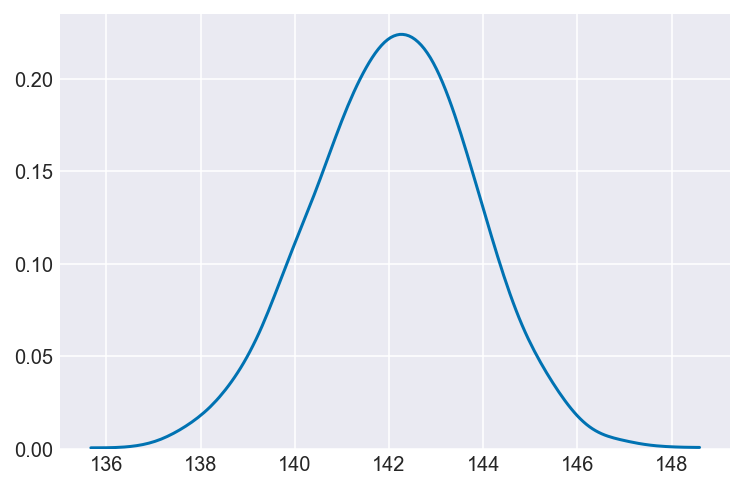

In [150]:
mu.male = trace_5_15['a'] + trace_5_15['bm']
pm.kdeplot(mu.male);
pm.hpd(mu.male) # 95% interval of average male height

**5.47**

Another way of computing average male and female heights:

In [145]:
with pm.Model() as m5_15b:
    af = pm.Normal('af',mu = 178, sd=100)
    am = pm.Normal('am',mu = 178, sd=100)
    mu = pm.Deterministic('mu',af * (1 - d['male']) + am * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, am, af]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:19<00:00, 201.79draws/s]


In [149]:
varnames = ['af', 'am', 'sigma']
pm.summary(trace_5_15b, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
af     134.647  1.546     0.034  132.400   137.353  2585.617   1.0
am     142.364  1.723     0.026  139.778   145.182  3086.366   1.0
sigma   27.422  0.827     0.016   26.050    28.714  3109.561   1.0

## Multiple categories

When there are more than one variable, you'll need more than one dummy variable. To include k categories in a linear regression, you require k - 1 dummy variables. Each dummy variable indicates, with the value 1, a unique category. The category with no dummy variable assigned to itends up again as the "intercept" category. Let's explore, using the milk dataset again.

**5.48**

In [9]:
d = pd.read_csv('Data/milk.txt', sep=';')
d = d.drop_duplicates()
d.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

In [11]:
d.clade.value_counts()

Ape                 9
New World Monkey    9
Old World Monkey    6
Strepsirrhine       5
Name: clade, dtype: int64

Now you'll create dummy variables out of the `clade` column. We'll start with the new world monkey.

In [12]:
d['clade.NWM'] = np.where( d['clade'] == 'New World Monkey', 1, 0)
d['clade.NWM'].get_values()

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

**5.50**

Create dummy variables for the rest of the categories

In [14]:
d['clade.OWM'] = np.where( d['clade'] == 'Old World Monkey', 1, 0)
d['clade.S'] = np.where( d['clade'] == 'Strepsirrhine', 1, 0)

In [20]:
d[['clade.NWM','clade.OWM','clade.S']].tail()

clade.NWM  clade.OWM  clade.S
24          0          0        0
25          0          0        0
26          0          0        0
27          0          0        0
28          0          0        0

Ape will be the intercept category, so there is no need to include it as a dummy variable.

The model we aim to fit to the data is kcal.per.g (milk energy) regressed on the dummy variables for `clade`.

\begin{aligned}
k_i &\sim Normal(μ_i,σ)\\
μ_i &= α+β_NNWM_i + β_OOWM_i + β_SS_i\\
α &\sim Normal(0.6,10)\\
β_N &\sim Normal(0,1)\\
β_O &\sim Normal(0,1)\\
β_S &\sim Normal(0,1)\\
σ &\sim Uniform(0,10)
\end{aligned}

A linear model like this really defines four different linear models, each corresponding to a different category.

\begin{aligned}
μ_i &= α\\
μ_i &= α+β_N\\
μ_i &= α+β_O\\
μ_i &= α+β_S
\end{aligned}

Each category implies a different set of 1's and 0's in the dummy variable, which in turn implies a different equation for μ_i, once simplified. 

**5.51**

In [21]:
with pm.Model() as m5_16:
    a = pm.Normal('a', mu = 0.6, sd=10)
    b_NWM = pm.Normal('b_NWM',mu = 0, sd=1)
    b_OWM = pm.Normal('b_OWM',mu = 0, sd=1)
    b_S = pm.Normal('b_S',mu = 0, sd=1)
    mu = pm.Deterministic('mu', a + 
                          b_NWM * d['clade.NWM'] + 
                          b_OWM * d['clade.OWM'] +
                          b_S * d['clade.S'])
    
    # instead of adding this as a deterministic when running the model 
    # it is possible to add them, after sampling using something like this
    # trace_5_16.add_values({'mu_NWM', trace_5_16['a'] + trace_5_16['b_NWM']})
    mu_ape = pm.Deterministic('mu_ape', a + 0)
    mu_NWM = pm.Deterministic('mu_NWM', a + b_NWM)
    mu_OWM = pm.Deterministic('mu_OWM', a + b_OWM)
    mu_S =  pm.Deterministic('mu_S', a + b_S)
    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = mu, sd=sigma, observed = d['kcal.per.g'])
    trace_5_16 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_S, b_OWM, b_NWM, a]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:23<00:00, 169.34draws/s]


In [22]:
varnames = ['a', 'b_NWM', 'b_OWM', 'b_S', 'sigma']
pm.summary(trace_5_16, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      0.545  0.045     0.002    0.476     0.617   711.371  1.001
b_NWM  0.169  0.064     0.002    0.069     0.269   831.677  1.001
b_OWM  0.243  0.069     0.002    0.131     0.350   977.803  1.004
b_S   -0.038  0.077     0.002   -0.164     0.082   827.223  1.001
sigma  0.131  0.019     0.001    0.101     0.159  1344.253  1.002

The estimate `a` is the average milk energy for apes, and the estimates for the other categories are differences from apes. For example, the average milk energy for New World Monkeys is: a+b_NWM = 0.54+0.17=0.71

**5.52**

As a shortcut, to get the posterior distributions of the average milk energy in each category:

In [24]:
varnames = ['mu_ape', 'mu_NWM', 'mu_OWM', 'mu_S']
pm.summary(trace_5_16, varnames, alpha=.11).round(3)[['mean', 'sd', 'hpd_5.5', 'hpd_94.5']]

mean     sd  hpd_5.5  hpd_94.5
mu_ape  0.545  0.045    0.476     0.617
mu_NWM  0.714  0.045    0.641     0.783
mu_OWM  0.788  0.053    0.707     0.873
mu_S    0.507  0.061    0.404     0.598

**5.53**

Suppose you want to know the estimated difference between two monkey groups. Just subtract the estimated means to get the difference.

In [40]:
diff_NMW_OWM = trace_5_16['mu_NWM'] - trace_5_16['mu_OWM']

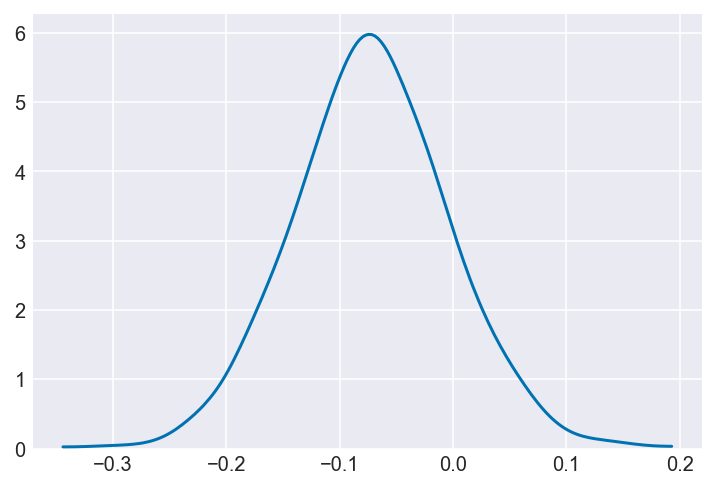

In [39]:
pm.kdeplot(diff_NMW_OWM)

In [41]:
np.percentile(diff_NMW_OWM, 2.5), np.percentile(diff_NMW_OWM, 50), np.percentile(diff_NMW_OWM, 97.5)

(-0.20719212731300418, -0.074253601114461, 0.060486531414612944)

These values are the posterior lower 95% boundary, the median, and the upper 95% boundary for the difference between the two monkey groups.

###  Adding Regular Predictor Variables

There is no obstacle now in including other predictor variables like perc.fat or log(mass). Just add them to the equation for the mean, like you normally would. For exapmle to add perc.fat to the model:

\begin{aligned}
μ_i &= α+β_NNWM_i + β_OOWM_i + β_SS_i + β_FF_i 
\end{aligned}

**The last cells (5.56-5.61) correspond to example code for the use of R's function: lm.**

In [60]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer AMD64 running   and using:
Python 3.6.4
IPython 6.2.1
PyMC3 3.5.rc1
NumPy 1.14.0
Pandas 0.22.0
SciPy 1.0.0
Matplotlib 2.1.2
Seaborn 0.8.1

